<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1>Práctico Aprendizaje Profundo</h1>

**Integrantes:** Johanna Frau, Sofía Luján y Nair Trógolo.

El objetivo de este trabajo es predecir la velocidad de adopción de un conjunto de mascotas utilizando distintos modelos de aprendizaje profundo sobre el conjunto de datos de petfinder. 

El mismo tiene dos partes, en primera instancia, implementamos y entrenamos modelos básicos de aprendizaje profundo, multilayer perceptron,  (ejercicio 1). Luego, en la segunda parte (ejercicio 2), exploramos distintas combinaciones de hiperparamétros y analizamos cómo estas pueden influir en la performance del modelo.



### Instalación de tensorflow

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

TensorFlow 2.x selected.


In [0]:
!pip install mlflow

     |████████████████████████████████| 14.6MB 2.8MB/s 
     |████████████████████████████████| 1.1MB 36.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 460kB 49.9MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 143kB 47.3MB/s 
     |████████████████████████████████| 471kB 47.6MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 204kB 45.6MB/s 
  Created wheel for mlflow: filename=mlflow-1.4.0-cp36-none-any.whl size=14750368 sha256=8afa903982811dc79d22d126554fa5542ef252e34a1085173203e76b3a1224fd
  Stored in directory: /root/.cache/pip/wheels/5d/0e/cc/79315d41833b92a8a9e276716874f2c1dc654018b44632dc06
  Created wheel for alembic: filename=alembic-1.3.1-py2.py3-none-any.whl size=144523 sha256=fa035c5c010af20e39aa12668055781935e8880f62a4c08159e1d3b65f7b2794
  Stored in directory: /root/.cache/pip/wheels/b2/d4/19/5ab879d30af7cbc79e6dcc1d4217

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


### Visualización de la distribución del target

In [0]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')
train.head()

Type  Age  ...  AdoptionSpeed  PID
0     2    3  ...              2    0
1     1    4  ...              2    3
2     1    1  ...              2    4
3     2    3  ...              2    5
4     2   12  ...              1    6

[5 rows x 20 columns]

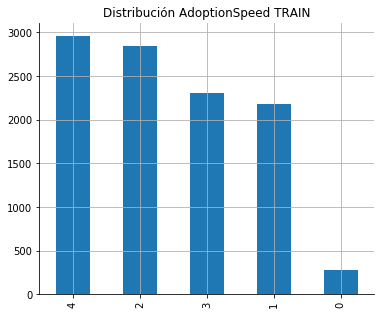

In [0]:
plt.figure(figsize=(6,5))
train['AdoptionSpeed'].value_counts(normalize=False,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución AdoptionSpeed TRAIN')
sns.despine()

En el gráfico anterior observamos que todas las clases presentan una distribución similar salvo la clase 0, con lo cual nos encontramos frente a un claro problema de desbalanceo de clases con una clase minoritaria. Esto podría influir en el análisis de los resultados.

### Instalación de mlflow

In [0]:
!pip install mlflow

# Ejercicio 1:  Descripción de los modelos

A continuación se entrenaron 3 modelos, utilizando como inputs las columnas 'Gender', 'Color1', 'Color2', 'Color3', 'Type', 'Age' y 'Fee', donde las 5 primeras han sido convertidas a valores numéricos y las últimas dos son las columnas originales del dataset. 


El modelo 1 consta de una capa de entrada con 28 neuronas, dos capas densas con 100 y 50 neuronas respectivamente y una capa de la salida con 4 outputs que corresponden a las 4 categorías que se desean predecir del adoption speed.
La primer capa oculta tiene un Dropout de 0.3, la segunda de 0.5. Utilizamos un batch_size=64 y el entrenamiento se realizó durante 100 épocas.

El modelo 2 consta de una capa de entrada con 28 neuronas, tres capas densas con 150, 75 y 30 neuronas respectivamente y una capa de la salida con 4 outputs que corresponden a las 4 categorías que se desean predecir del adoption speed.
La primer capa oculta tiene un Dropout de 0.3, la segunda de 0.5 y la tercera de 0.1. Utilizamos un batch_size=64 y el entrenamiento se realizó durante 100 épocas.

Por su parte, el 3er modelo es idéntico al segundo con la diferencia de que se han balanceado las 4 clases a predecir.

## Modelo 1

In [0]:
"""Exercise 1

Usage:

$ CUDA_VISIBLE_DEVICES=2 python practico_1_train_petfinder.py --dataset_dir ../ --epochs 30 --dropout 0.1 0.1 --hidden_layer_sizes 200 100

To know which GPU to use, you can check it with the command

$ nvidia-smi
"""

import argparse
import matplotlib.pyplot as plt
import os
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
TARGET_COL = 'AdoptionSpeed'
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
from ast import literal_eval




/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


**Funciones necesarias**

In [0]:
full_history = {}

In [0]:
def save_history(model_name, history):
  dic = {}
  dic['val_accuracy'] = history.history['val_accuracy']
  dic['accuracy'] = history.history['accuracy']
  dic['loss'] = history.history['loss']
  dic['val_loss'] = history.history['val_loss']
  full_history[model_name] = dic
  
  

In [0]:
def get_mlflow_runs(query):
  all_experiments = [exp.experiment_id for exp in MlflowClient().list_experiments()]
  runs = MlflowClient().search_runs(all_experiments, query, ViewType.ALL)


  df = pd.DataFrame()
  for each in runs:
    dic = each.to_dictionary()
    metric = dic['data']['metrics']
    params = dic['data']['params']
    tags  = dic['data']['tags']
    info = dic['info']

    metric.update(params)
    metric.update(tags)
    metric.update(info)
    metric.pop('optimizer')

    for key,value in literal_eval(dic['data']['params']['optimizer']).items():
      metric['optimizer_'+key] = value
    
    df = df.append(pd.DataFrame([metric]))

  return df

In [0]:

def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)
    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    #features = layers.concatenate(embedding_layers + [direct_features_input])
    features = direct_features_input
    dense1 = layers.Dense(100, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(50, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout2)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [100,50],
      'dropout': [0.3, 0.5],
      'dataset_dir' : '',
      'batch_size' : 64,
      'epochs' : 100,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2']
    }
    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
    
    #predictions = model.predict(test_ds)
    #print(predictions)
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '1') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,12))
        
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
                
        plt.subplot(2,1,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch',size='18')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
direct_features (InputLayer)    [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2900        direct_features[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           5050     

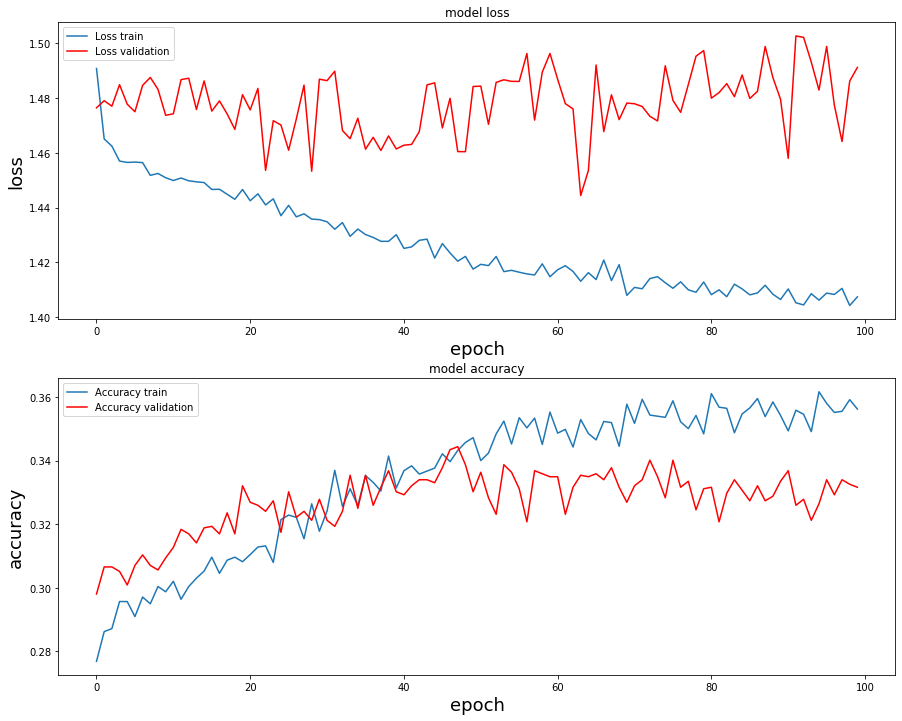

All operations completed


In [0]:
main()

## Modelo 2

In [0]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, oversampling=False):

    # Read train dataset (and maybe dev, if you need to...)
    #dataset = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))
    dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')

    #dataset, dev_dataset = train_test_split(
     #   pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
      #  test_size=0.2)
    if(oversampling):
      print('Category count {}'.format(dataset.shape[0]))
      dataset['AdoptionSpeed'].value_counts()
      ros = RandomOverSampler(random_state=0)
      X_resampled, y_resampled = ros.fit_resample(dataset.drop(['Description','AdoptionSpeed','PID'], axis=1), dataset['AdoptionSpeed'])
      X_resampled = pd.DataFrame(X_resampled)
      X_resampled.columns = dataset.drop(['Description','AdoptionSpeed','PID'], axis=1).columns
      y_resampled = pd.DataFrame(y_resampled)
      y_resampled.columns = ['AdoptionSpeed']
      dataset = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
      print('Category count after oversampling {}'.format(dataset.shape[0]))
    
    dataset, dev_dataset = train_test_split(dataset, test_size=0.2)
    
    #test_dataset = pd.read_csv(os.path.join(dataset_dir, 'test.csv'))
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')

    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset



def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    #features = layers.concatenate(embedding_layers + [direct_features_input])
    features = direct_features_input
    dense1 = layers.Dense(150, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(75, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(30, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.1)(dense3)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [150,75,30],
      'dropout': [0.3, 0.5, 0.1],
      'dataset_dir' : '',
      'batch_size' : 64,
      'epochs' : 100,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], False)
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2']
    }
    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
    
    #predictions = model.predict(test_ds)
    #print(predictions)
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '1') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('2', history)
        
        
        #grafico
        plt.figure(figsize=(15,12))
        
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
                
        plt.subplot(2,1,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch',size='18')
        plt.legend()
        plt.show()
        
    print('All operations completed')


Training samples 8465, test_samples 4411
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
direct_features (InputLayer)    [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          4350        direct_features[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 150)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 75)           11325    

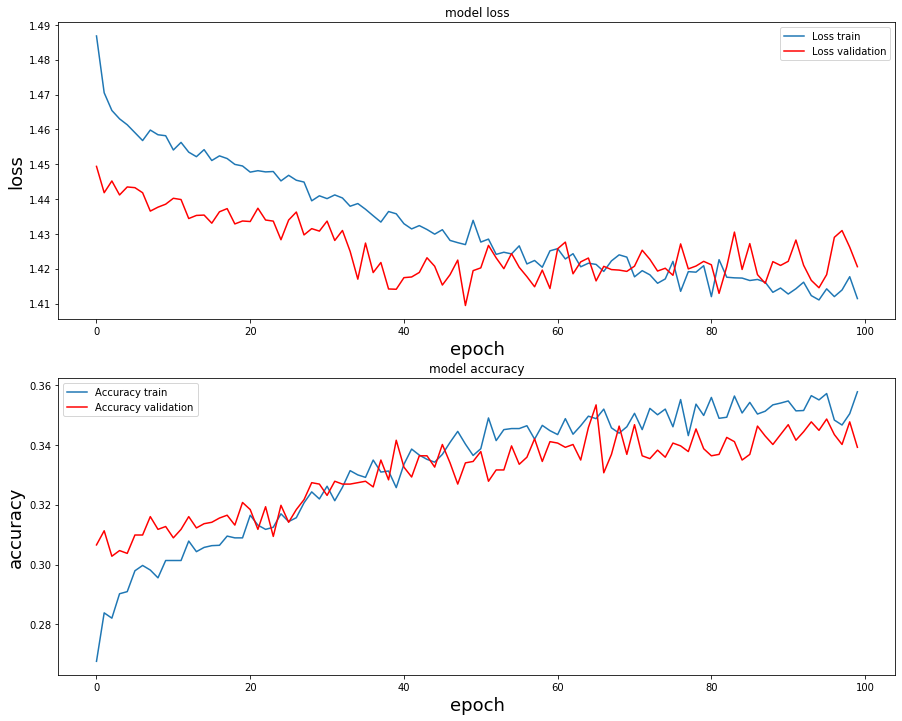

All operations completed


In [0]:
main()

## Modelo 3: oversampled

In [0]:
def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [150,75,30],
      'dropout': [0.3, 0.5, 0.1],
      'dataset_dir' : '',
      'batch_size' : 64,
      'epochs' : 100,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], True)
    #dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')

    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2']
    }
    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
    
    #predictions = model.predict(test_ds)
    #print(predictions)
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '1') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('3', history)
        
        
        #grafico
        plt.figure(figsize=(15,12))
        
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
                
        plt.subplot(2,1,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch',size='18')
        plt.legend()
        plt.show()
        
    print('All operations completed')


Category count 10582
Category count after oversampling 14820
Training samples 11856, test_samples 4411
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
direct_features (InputLayer)    [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          4350        direct_features[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 150)          0           dense[0][0]                      
__________________________________________________________________________________________________


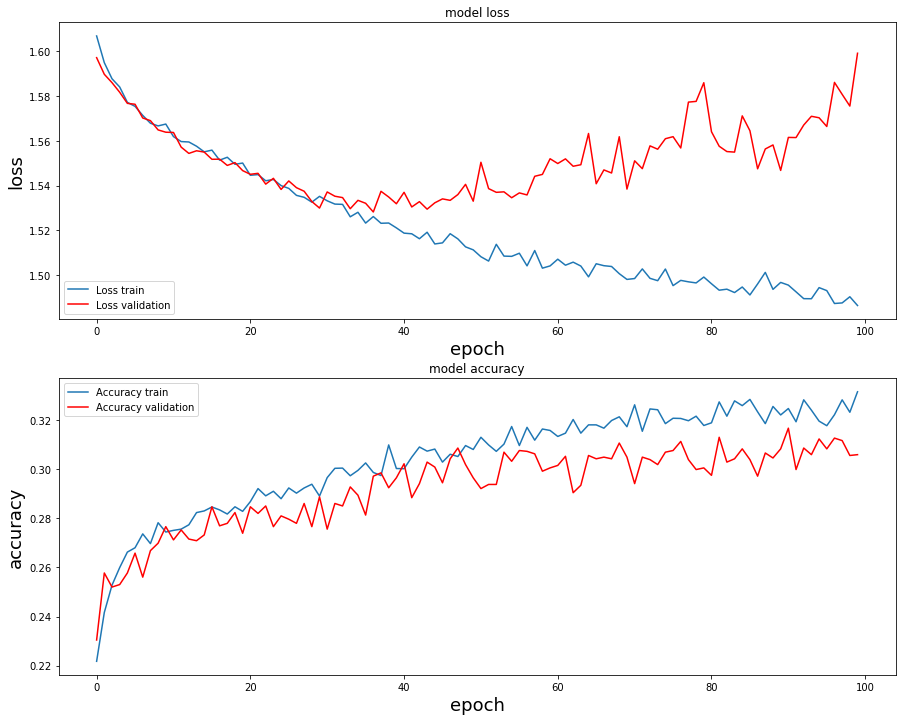

All operations completed


In [0]:
main()

In [0]:
full_history.keys()

dict_keys(['1', '2', '3'])

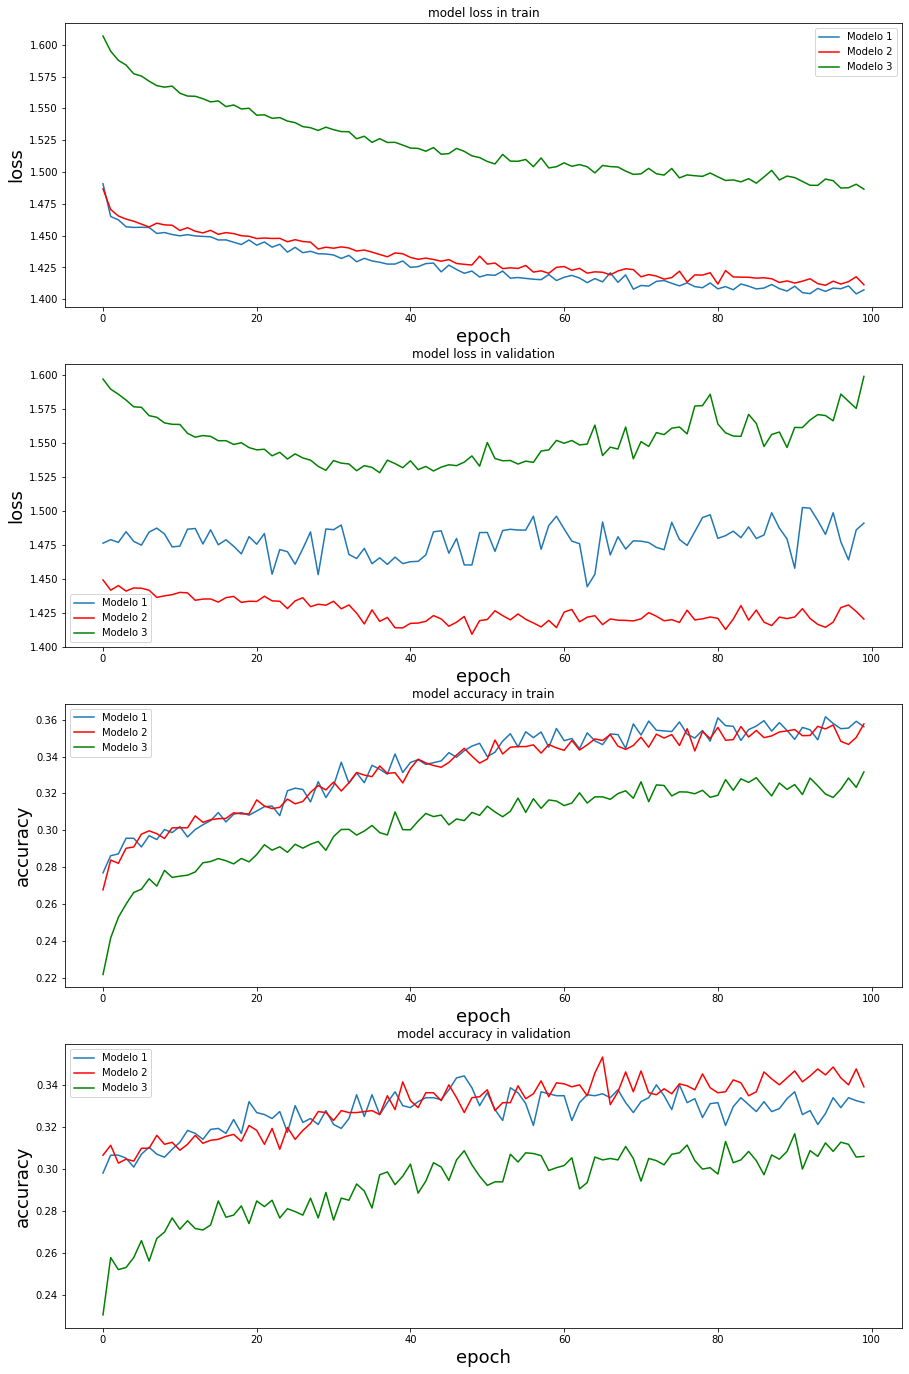

In [0]:

        #grafico
        plt.figure(figsize=(15,24))
        
        plt.subplot(4,1,1)
        plt.plot(full_history['1']['loss'], label='Modelo 1')
        plt.plot(full_history['2']['loss'], color='red', label='Modelo 2')
        plt.plot(full_history['3']['loss'], color='green', label='Modelo 3')
        plt.title('model loss in train')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
        
        plt.subplot(4,1,2)
        plt.plot(full_history['1']['val_loss'], label='Modelo 1')
        plt.plot(full_history['2']['val_loss'], color='red', label='Modelo 2')
        plt.plot(full_history['3']['val_loss'], color='green', label='Modelo 3')
        plt.title('model loss in validation')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
        
        plt.subplot(4,1,3)
        plt.plot(full_history['1']['accuracy'], label='Modelo 1')
        plt.plot(full_history['2']['accuracy'], color='red', label='Modelo 2')
        plt.plot(full_history['3']['accuracy'], color='green', label='Modelo 3')
        plt.title('model accuracy in train')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
                
                
        plt.subplot(4,1,4)
        plt.plot(full_history['1']['val_accuracy'], label='Modelo 1')
        plt.plot(full_history['2']['val_accuracy'], color='red', label='Modelo 2')
        plt.plot(full_history['3']['val_accuracy'], color='green', label='Modelo 3')
        plt.title('model accuracy in validation')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
        
        plt.show()
       

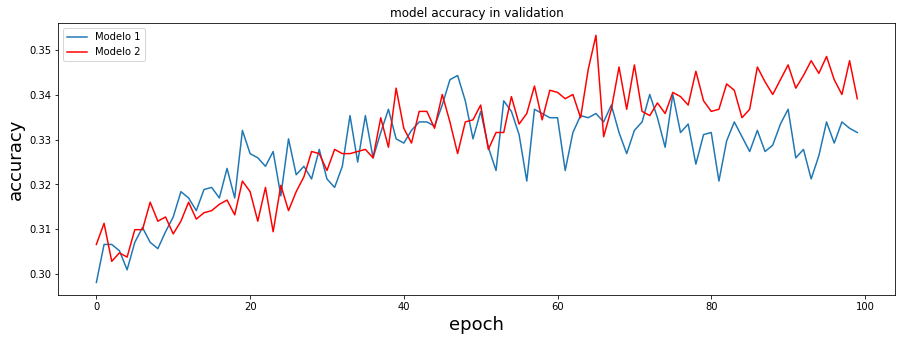

In [0]:
plt.figure(figsize=(15,5))

plt.plot(full_history['1']['val_accuracy'], label='Modelo 1')
plt.plot(full_history['2']['val_accuracy'], color='red', label='Modelo 2')
plt.title('model accuracy in validation')
plt.ylabel('accuracy', size='18')
plt.xlabel('epoch', size='18')
plt.legend()
plt.show()

In [0]:
query = ""

get_mlflow_runs(query)

dev-loss  dev-accuracy  ...  optimizer_epsilon  optimizer_amsgrad
0  1.598273      0.306005  ...       1.000000e-07               True
0  1.422560      0.339159  ...       1.000000e-07               True
0  1.505988      0.331601  ...       1.000000e-07               True

[3 rows x 33 columns]

. 


# Análisis de resultados

### Modelo 1: 
Al cabo de 100 épocas se observa que el error de entrenamiento (loss) continúa bajando, el error de validación se mantiene prácticamente constante. Se logra un accuracy tanto en train como en validación de 0.35.


### Modelo 2:
El error de entrenamiento decae sistemáticamente a medida que aumentamos las épocas. Sin embargo, el error de validación comienza a crecer a partir de las 40 épocas. Se logra un accuracy en train de 0.35 y en validación de 0.33.



### Modelo 3: 
El error de entrenamiento decae sistemáticamente a medida que aumentamos las épocas. Sin embargo, el error de validación comienza a crecer abruptamente a partir de las 40 épocas. Se logra un accuracy en train de 0.32 y en validación de 0.29. 


# Conclusiones:
Los últimos dos gráficos nos muestran los desempeños de los 3 modelos. Resultando el modelo más simple, el primero, el más apropiado. Por presentar el menor error de prediccón y un valor mayor en el accuracy (0.35). 
A diferencia de lo que pensábamos, balancear las clases no mejoró las predicciones.



**Nota:** en esta notebook se han realizado los embeddings correspondiente a los features 'Breed1' y 'Breed2', que serán utilizados en el ejercicio 2. 

# Ejercicio 2 :Consignas

* Utilizar el mismo modelo anterior y explorar cómo cambian los resultados a medida que agregamos o quitamos columnas.

* Volver a ejecutar una exploración de hyperparámetros teniendo en cuenta la información que agregan las nuevas columnas.

* Subir los resultados a la competencia de Kaggle.

### MODELO 1

In [0]:
#train['State'].unique()
train = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')


In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(50, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(100, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(75, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [100,50],
      'dropout': [0.3, 0.5],
      'dataset_dir' : '',
      'batch_size' : 64,
      'epochs' : 100,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2','State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________

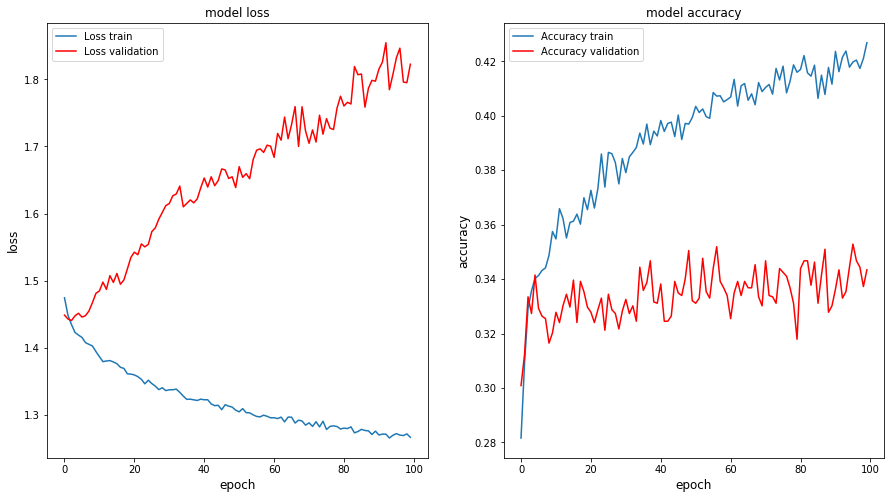

All operations completed


In [0]:
main()

### Search params hidden layer 20-500 

In [0]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.5MB/s 


In [0]:
def load_dataset():
    #dataset, dev_dataset = train_test_split(pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), test_size=0.2)
    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), test_size=0.2)
    # Read train dataset (and maybe dev, if you need to...)
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

In [0]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets

In [0]:
from skopt.space import Real, Integer, Categorical


search_space = {
  "batch_size": Integer(50, 100, name="batch_size"),
  "hidden_layer_size_1": Integer(10, 100, name="hidden_layer_size_1"),
  "hidden_layer_size_2": Integer(10, 100, name="hidden_layer_size_2"),
  "hidden_layer_size_3": Integer(10, 100, name="hidden_layer_size_3"),
  "learning_rate": Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate')

}
# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx
                     for idx, param_name in enumerate(search_space_keys)}
print(search_space)

def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

{'batch_size': Integer(low=50, high=100), 'hidden_layer_size_1': Integer(low=10, high=100), 'hidden_layer_size_2': Integer(low=10, high=100), 'hidden_layer_size_3': Integer(low=10, high=100), 'learning_rate': Real(low=1e-05, high=0.001, prior='log-uniform', transform='identity')}


In [0]:
def objective_function(params):
    print_selected_hyperparams(params)
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    batch_size = hyperparam_value("batch_size", params)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)

    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])

    hidden_layer_size_1 = hyperparam_value("hidden_layer_size_1", params)
    hidden_layer_size_2 = hyperparam_value("hidden_layer_size_2", params)
    hidden_layer_size_3 = hyperparam_value("hidden_layer_size_3", params)
    #features = direct_features_input
    dense1 = layers.Dense(hidden_layer_size_1, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(hidden_layer_size_2, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(hidden_layer_size_3, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    # Build model
    learning_rate = hyperparam_value("learning_rate", params)
    model = models.Model(inputs=inputs, outputs=output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    epochs = 20
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', [hidden_layer_size_1, hidden_layer_size_2,hidden_layer_size_3])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', epochs)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('dropout', [0.3, 0.5,0.5])
        mlflow.log_param('loss', 'categorical_crossentropy')
        mlflow.log_param('optimizer', 'Adam')
        
    
        # Train
        
        history = model.fit(train_ds, epochs=epochs, validation_data=dev_ds)

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')
    
    return loss

In [0]:
from skopt import gp_minimize

In [0]:
def show_best(res):
    print("Best value: %.4f" % res.fun)
    param_names = {idx: param_name for param_name, idx in search_space_keys.items()}
    best_params = {param_names[i]: param_value for i, param_value in enumerate(res.x)}
    print("Best params:")
    print(best_params)  

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Iteration No: 1 started. Evaluating function at random point.
	 batch_size 130
	 hidden_layer_size_1 346
	 hidden_layer_size_2 37
	 hidden_layer_size_3 477
	 learning_rate 0.00024851120302176203
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
66/66 [==============================] - 2s 28ms/step - loss: 1.5308 - accuracy: 0.2666 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
66/66 [==============================] - 0s 7ms/step - loss: 1.5027 - accuracy: 0.2600 - val_loss: 1.4584 - val_accuracy: 0.2929
Epoch 3/20
66/66 [==============================] - 0s 7ms/step - loss: 1.4889 - accuracy: 0.2706 - val_loss: 1.4507 - val_accuracy: 0.3099
Epoch 4/20
66/66 [==============================] - 0s 7ms/step - loss: 1.4778 - accuracy: 0.2803 - val_loss: 1.4437 - val_accuracy: 0.3113
Epoch 5/20
66/66 [

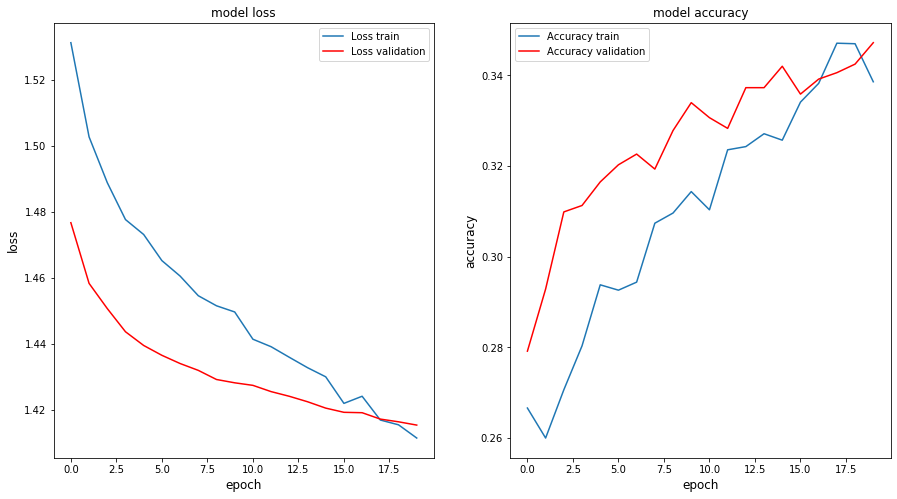

All operations completed
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.6960
Function value obtained: 1.3822
Current minimum: 1.3822
Iteration No: 2 started. Evaluating function at random point.
	 batch_size 66
	 hidden_layer_size_1 426
	 hidden_layer_size_2 183
	 hidden_layer_size_3 416
	 learning_rate 2.23543231654678e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
129/129 [==============================] - 2s 16ms/step - loss: 1.5657 - accuracy: 0.2490 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
129/129 [==============================] - 1s 7ms/step - loss: 1.5230 - accuracy: 0.2660 - val_loss: 1.4972 - val_accuracy: 0.2995
Epoch 3/20
129/129 [==============================] - 1s 7ms/step - loss: 1.4985 - accuracy: 0.2663 - val_loss: 1.4780 - val_accuracy: 0.3037
Epoch 4/20
129/129 [==============================] - 1s 6ms/step - loss: 1.4880 -

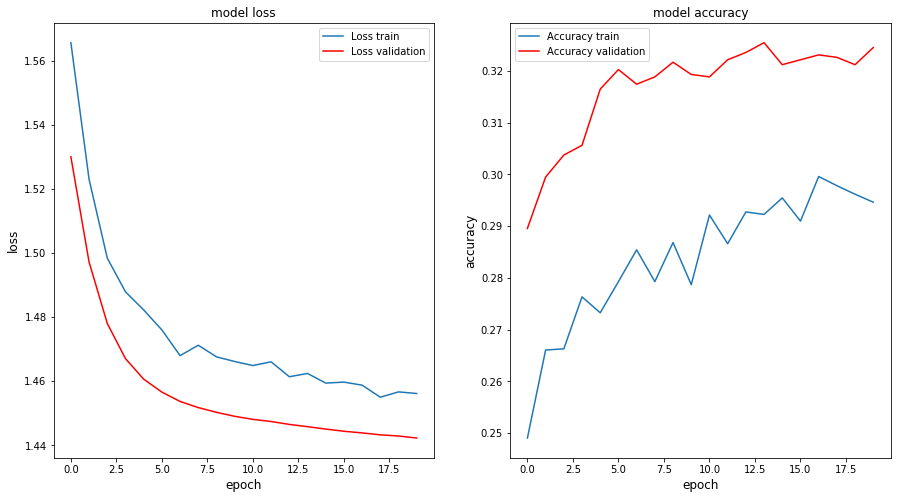

All operations completed
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.3019
Function value obtained: 1.4410
Current minimum: 1.3822
Iteration No: 3 started. Evaluating function at random point.
	 batch_size 96
	 hidden_layer_size_1 67
	 hidden_layer_size_2 390
	 hidden_layer_size_3 200
	 learning_rate 7.103278792699526e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
89/89 [==============================] - 2s 24ms/step - loss: 1.5684 - accuracy: 0.2424 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
89/89 [==============================] - 1s 6ms/step - loss: 1.5145 - accuracy: 0.2729 - val_loss: 1.4903 - val_accuracy: 0.3023
Epoch 3/20
89/89 [==============================] - 1s 6ms/step - loss: 1.4862 - accuracy: 0.2742 - val_loss: 1.4684 - val_accuracy: 0.3028
Epoch 4/20
89/89 [==============================] - 1s 7ms/step - loss: 1.4762 - accurac

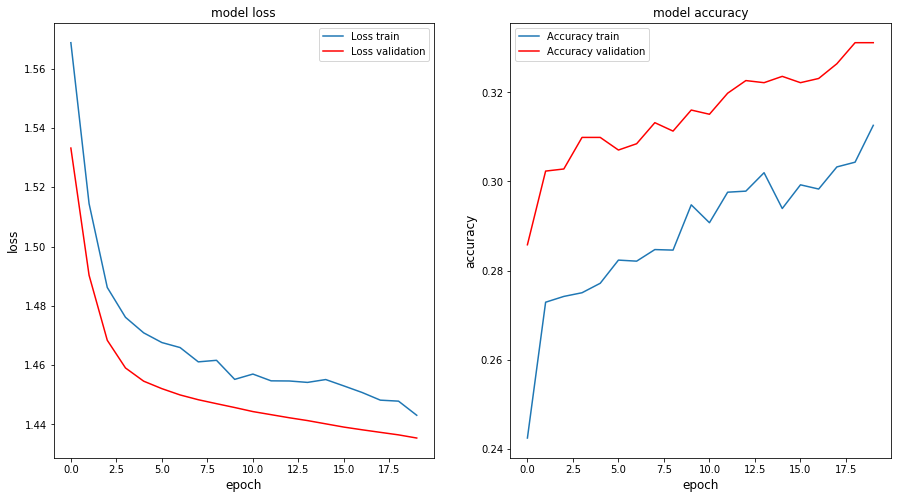

All operations completed
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.7057
Function value obtained: 1.4335
Current minimum: 1.3822
Iteration No: 4 started. Evaluating function at random point.
	 batch_size 147
	 hidden_layer_size_1 155
	 hidden_layer_size_2 299
	 hidden_layer_size_3 260
	 learning_rate 3.8205733833214285e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
58/58 [==============================] - 1s 26ms/step - loss: 1.5942 - accuracy: 0.2347 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 1.5500 - accuracy: 0.2506 - val_loss: 1.5213 - val_accuracy: 0.2924
Epoch 3/20
58/58 [==============================] - 0s 7ms/step - loss: 1.5253 - accuracy: 0.2624 - val_loss: 1.4973 - val_accuracy: 0.3023
Epoch 4/20
58/58 [==============================] - 0s 7ms/step - loss: 1.5048 - accu

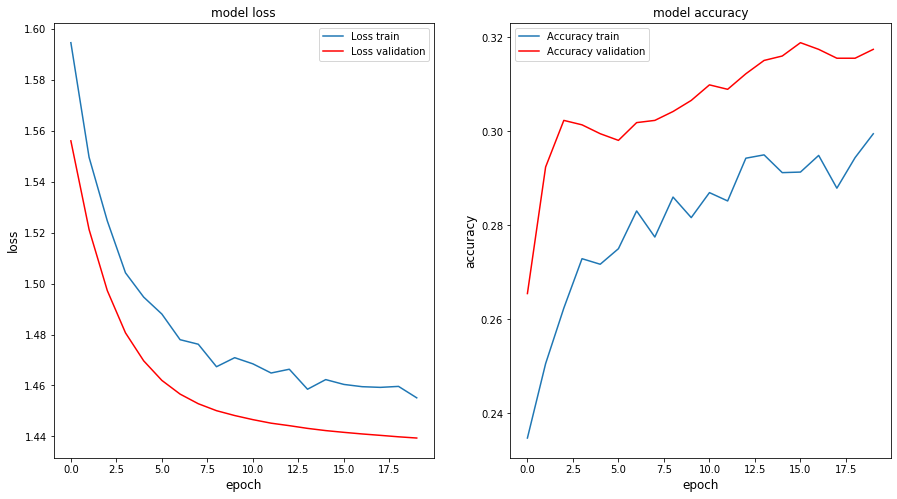

All operations completed
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.3856
Function value obtained: 1.4430
Current minimum: 1.3822
Iteration No: 5 started. Evaluating function at random point.
	 batch_size 107
	 hidden_layer_size_1 440
	 hidden_layer_size_2 465
	 hidden_layer_size_3 479
	 learning_rate 3.8504828866809955e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
80/80 [==============================] - 2s 26ms/step - loss: 1.5707 - accuracy: 0.2409 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
80/80 [==============================] - 1s 6ms/step - loss: 1.5020 - accuracy: 0.2809 - val_loss: 1.4752 - val_accuracy: 0.3028
Epoch 3/20
80/80 [==============================] - 1s 6ms/step - loss: 1.4820 - accuracy: 0.2761 - val_loss: 1.4590 - val_accuracy: 0.3014
Epoch 4/20
80/80 [==============================] - 1s 6ms/step - loss: 1.4696 - accu

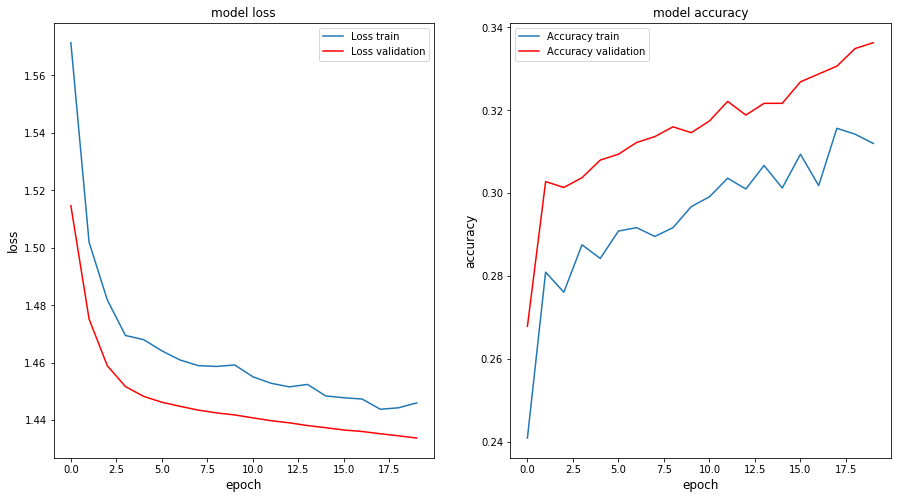

All operations completed
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.2379
Function value obtained: 1.4300
Current minimum: 1.3822
Iteration No: 6 started. Evaluating function at random point.
	 batch_size 73
	 hidden_layer_size_1 148
	 hidden_layer_size_2 61
	 hidden_layer_size_3 380
	 learning_rate 5.899656580061398e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
116/116 [==============================] - 2s 17ms/step - loss: 1.6298 - accuracy: 0.2057 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5677 - accuracy: 0.2545 - val_loss: 1.5259 - val_accuracy: 0.2886
Epoch 3/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5386 - accuracy: 0.2561 - val_loss: 1.4982 - val_accuracy: 0.2981
Epoch 4/20
116/116 [==============================] - 1s 7ms/step - loss: 1.5204 -

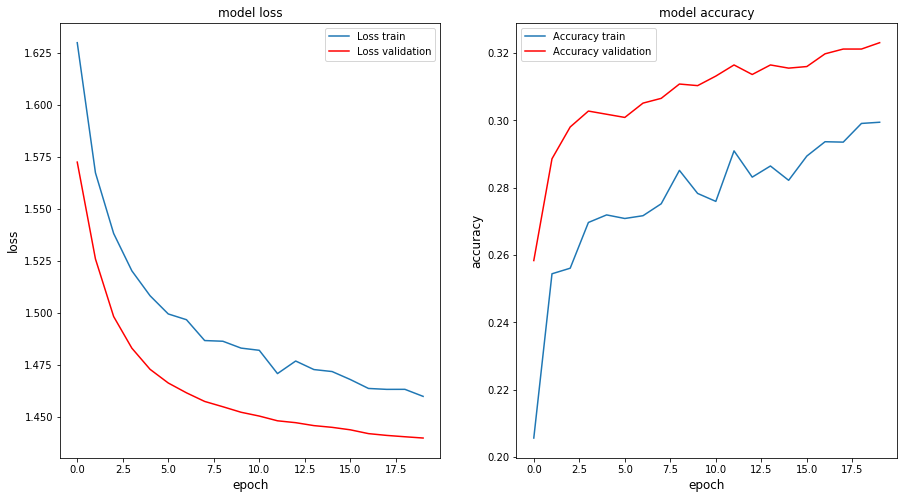

All operations completed
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.7356
Function value obtained: 1.4390
Current minimum: 1.3822
Iteration No: 7 started. Evaluating function at random point.
	 batch_size 111
	 hidden_layer_size_1 98
	 hidden_layer_size_2 213
	 hidden_layer_size_3 406
	 learning_rate 0.0001207316841183635
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
77/77 [==============================] - 2s 26ms/step - loss: 1.5414 - accuracy: 0.2573 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
77/77 [==============================] - 1s 7ms/step - loss: 1.4909 - accuracy: 0.2745 - val_loss: 1.4626 - val_accuracy: 0.2872
Epoch 3/20
77/77 [==============================] - 0s 6ms/step - loss: 1.4809 - accuracy: 0.2698 - val_loss: 1.4523 - val_accuracy: 0.2995
Epoch 4/20
77/77 [==============================] - 0s 6ms/step - loss: 1.4709 - accura

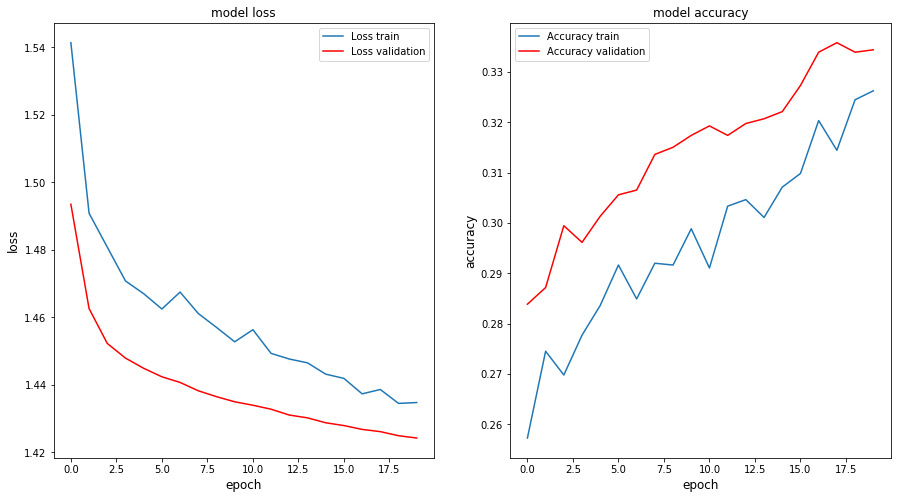

All operations completed
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.0780
Function value obtained: 1.4195
Current minimum: 1.3822
Iteration No: 8 started. Evaluating function at random point.
	 batch_size 126
	 hidden_layer_size_1 211
	 hidden_layer_size_2 405
	 hidden_layer_size_3 427
	 learning_rate 1.4608238804985995e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
68/68 [==============================] - 2s 23ms/step - loss: 1.6102 - accuracy: 0.2151 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
68/68 [==============================] - 0s 7ms/step - loss: 1.5822 - accuracy: 0.2385 - val_loss: 1.5632 - val_accuracy: 0.2744
Epoch 3/20
68/68 [==============================] - 0s 7ms/step - loss: 1.5591 - accuracy: 0.2552 - val_loss: 1.5422 - val_accuracy: 0.2933
Epoch 4/20
68/68 [==============================] - 0s 6ms/step - loss: 1.5407 - accu

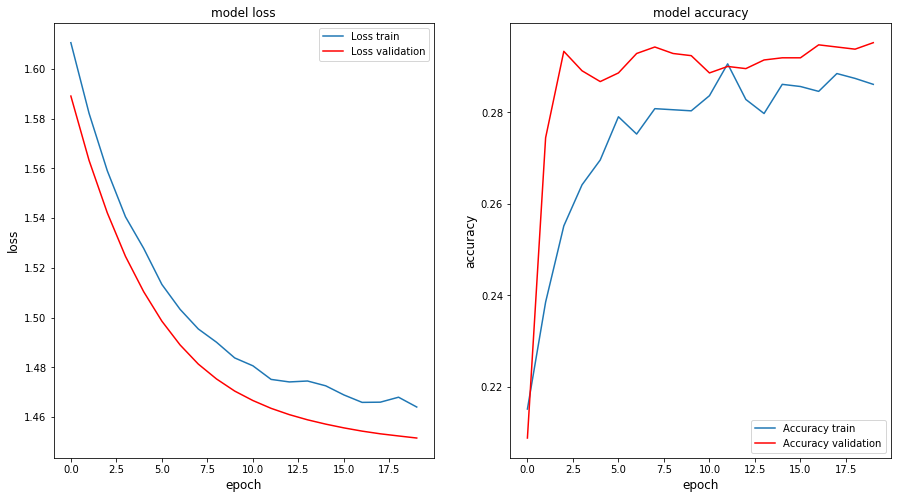

All operations completed
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 11.5414
Function value obtained: 1.4520
Current minimum: 1.3822
Iteration No: 9 started. Evaluating function at random point.
	 batch_size 144
	 hidden_layer_size_1 271
	 hidden_layer_size_2 315
	 hidden_layer_size_3 385
	 learning_rate 2.6988380143428105e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
59/59 [==============================] - 2s 33ms/step - loss: 1.5659 - accuracy: 0.2556 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 1.5325 - accuracy: 0.2591 - val_loss: 1.5064 - val_accuracy: 0.2900
Epoch 3/20
59/59 [==============================] - 0s 7ms/step - loss: 1.5099 - accuracy: 0.2595 - val_loss: 1.4868 - val_accuracy: 0.2891
Epoch 4/20
59/59 [==============================] - 0s 7ms/step - loss: 1.4949 - accu

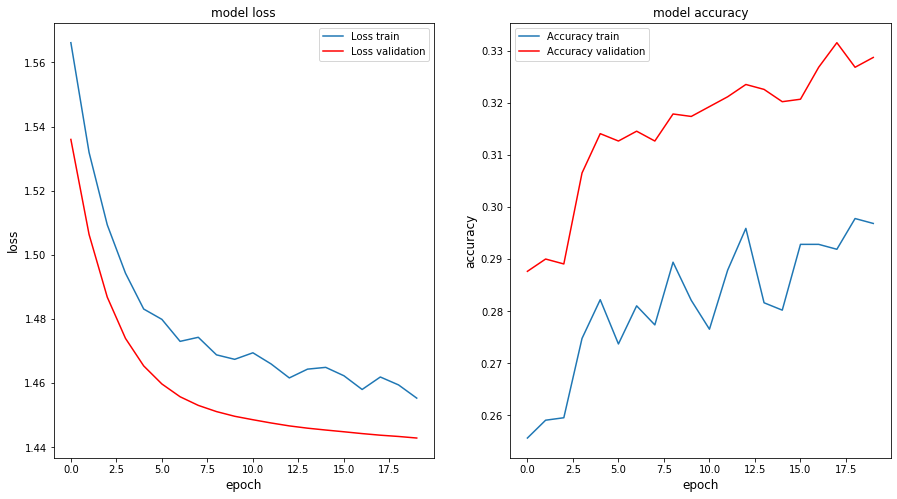

All operations completed
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.0917
Function value obtained: 1.4448
Current minimum: 1.3822
Iteration No: 10 started. Evaluating function at random point.
	 batch_size 139
	 hidden_layer_size_1 388
	 hidden_layer_size_2 223
	 hidden_layer_size_3 419
	 learning_rate 1.141812796139562e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
61/61 [==============================] - 2s 25ms/step - loss: 1.6243 - accuracy: 0.2082 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
61/61 [==============================] - 0s 6ms/step - loss: 1.5960 - accuracy: 0.2371 - val_loss: 1.5710 - val_accuracy: 0.2574
Epoch 3/20
61/61 [==============================] - 0s 7ms/step - loss: 1.5742 - accuracy: 0.2506 - val_loss: 1.5510 - val_accuracy: 0.2877
Epoch 4/20
61/61 [==============================] - 0s 7ms/step - loss: 1.5570 - accu

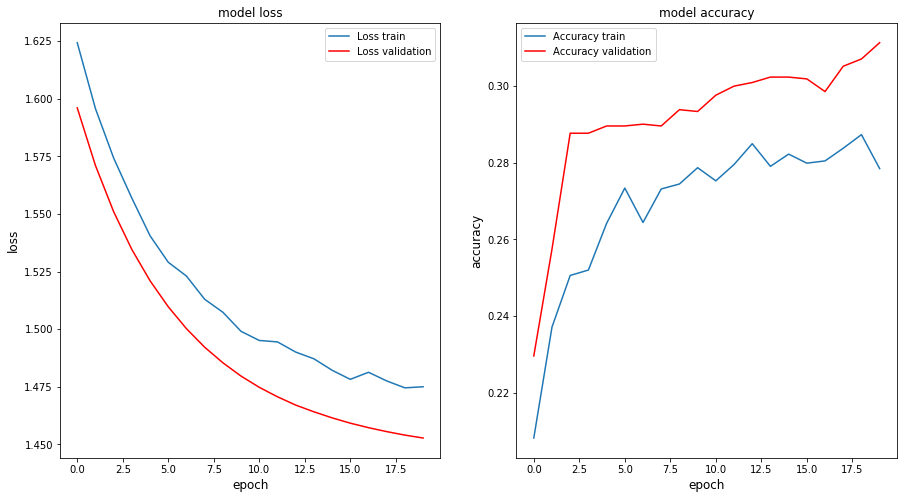

All operations completed
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.3385
Function value obtained: 1.4578
Current minimum: 1.3822
Iteration No: 11 started. Searching for the next optimal point.
	 batch_size 150
	 hidden_layer_size_1 500
	 hidden_layer_size_2 500
	 hidden_layer_size_3 500
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
57/57 [==============================] - 2s 32ms/step - loss: 1.4744 - accuracy: 0.2827 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 0s 6ms/step - loss: 1.4482 - accuracy: 0.3068 - val_loss: 1.4215 - val_accuracy: 0.3368
Epoch 3/20
57/57 [==============================] - 0s 7ms/step - loss: 1.4331 - accuracy: 0.3245 - val_loss: 1.4128 - val_accuracy: 0.3330
Epoch 4/20
57/57 [==============================] - 0s 7ms/step - loss: 1.4163 - accuracy: 0.3388 -

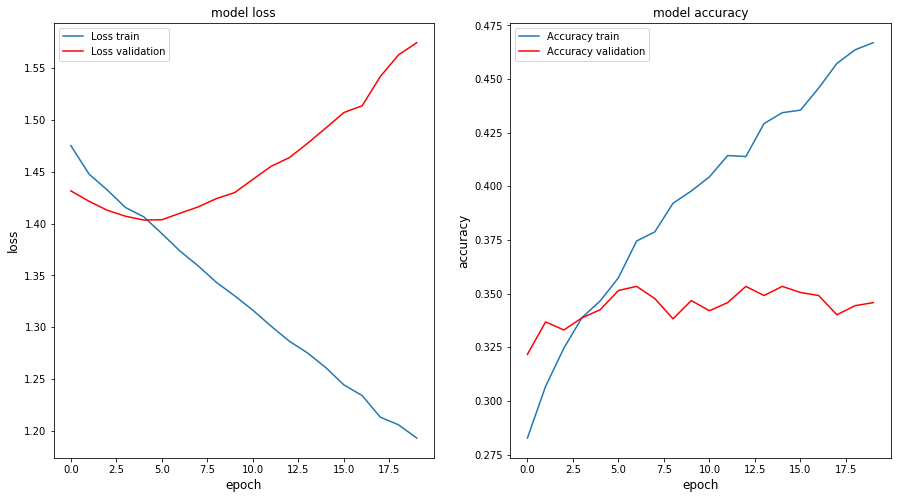

All operations completed
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.2602
Function value obtained: 1.1116
Current minimum: 1.1116
Iteration No: 12 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 20
	 hidden_layer_size_2 500
	 hidden_layer_size_3 20
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4784 - accuracy: 0.2736 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 7ms/step - loss: 1.4508 - accuracy: 0.2934 - val_loss: 1.4348 - val_accuracy: 0.3250
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4419 - accuracy: 0.3167 - val_loss: 1.4274 - val_accuracy: 0.3278
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4290 - ac

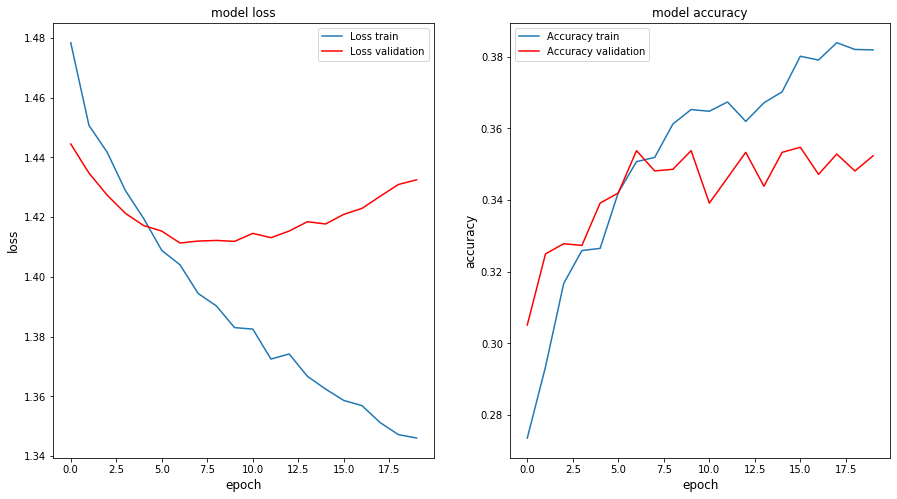

All operations completed
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 25.4383
Function value obtained: 1.3032
Current minimum: 1.1116
Iteration No: 13 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 20
	 hidden_layer_size_2 500
	 hidden_layer_size_3 500
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 3s 16ms/step - loss: 1.4774 - accuracy: 0.2788 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4503 - accuracy: 0.2998 - val_loss: 1.4291 - val_accuracy: 0.3297
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4391 - accuracy: 0.3118 - val_loss: 1.4207 - val_accuracy: 0.3349
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4289 - a

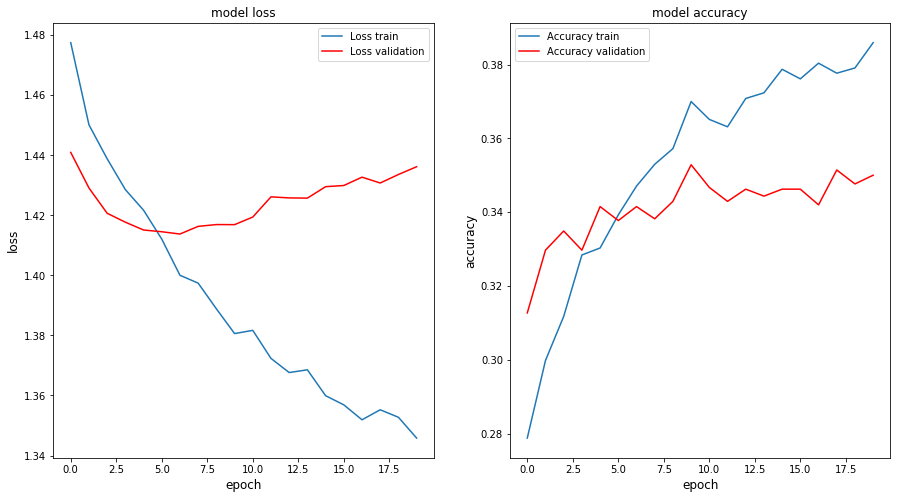

All operations completed
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 25.1655
Function value obtained: 1.3035
Current minimum: 1.1116
Iteration No: 14 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 500
	 hidden_layer_size_2 20
	 hidden_layer_size_3 20
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4918 - accuracy: 0.2676 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4625 - accuracy: 0.2919 - val_loss: 1.4311 - val_accuracy: 0.3250
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4494 - accuracy: 0.3070 - val_loss: 1.4266 - val_accuracy: 0.3420
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4408 - ac

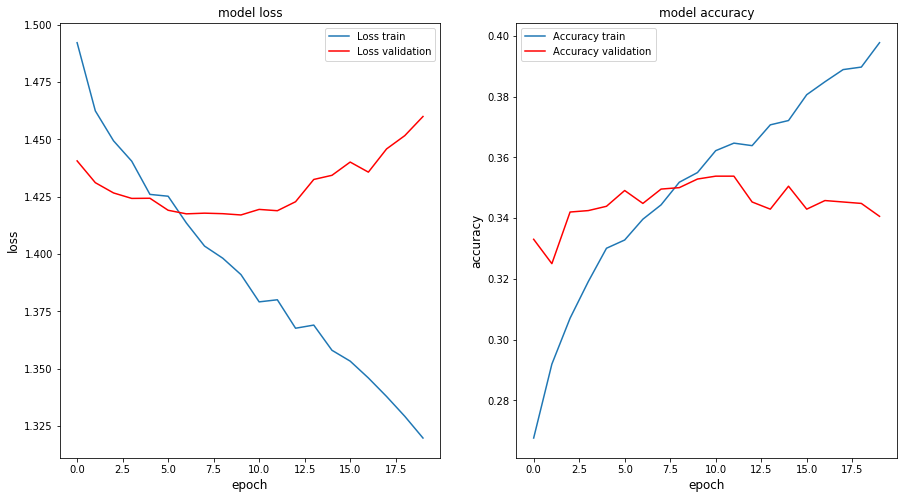

All operations completed
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 25.0532
Function value obtained: 1.2531
Current minimum: 1.1116
Iteration No: 15 started. Searching for the next optimal point.
	 batch_size 62
	 hidden_layer_size_1 480
	 hidden_layer_size_2 496
	 hidden_layer_size_3 82
	 learning_rate 0.000991207556254366
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
137/137 [==============================] - 2s 15ms/step - loss: 1.4698 - accuracy: 0.2918 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
137/137 [==============================] - 1s 6ms/step - loss: 1.4403 - accuracy: 0.3135 - val_loss: 1.4187 - val_accuracy: 0.3335
Epoch 3/20
137/137 [==============================] - 1s 6ms/step - loss: 1.4236 - accuracy: 0.3327 - val_loss: 1.4145 - val_accuracy: 0.3420
Epoch 4/20
137/137 [==============================] - 1s 6ms/step - l

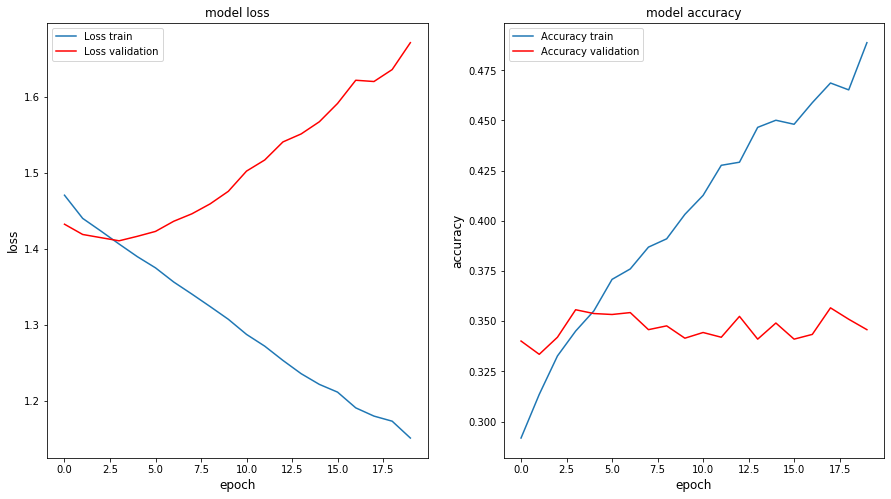

All operations completed
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 21.1425
Function value obtained: 1.0631
Current minimum: 1.0631
Iteration No: 16 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 500
	 hidden_layer_size_2 500
	 hidden_layer_size_3 20
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4692 - accuracy: 0.2826 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4429 - accuracy: 0.3096 - val_loss: 1.4214 - val_accuracy: 0.3363
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4230 - accuracy: 0.3309 - val_loss: 1.4159 - val_accuracy: 0.3401
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4052 - a

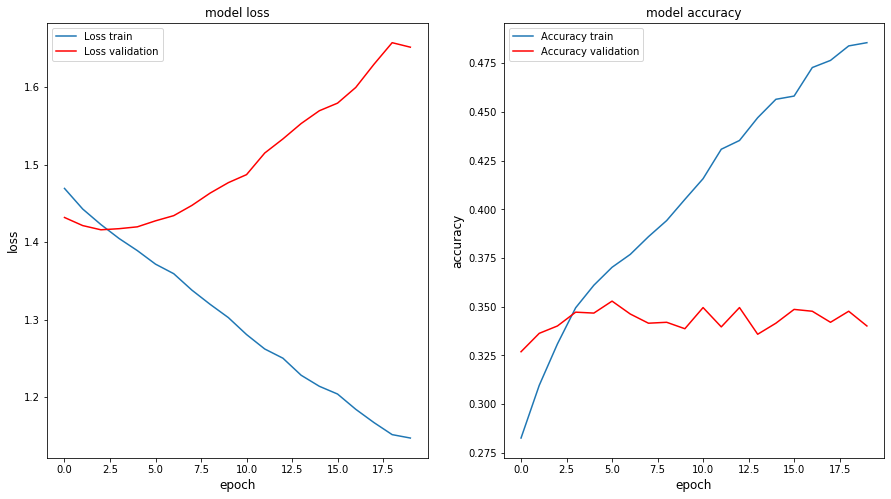

All operations completed
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 24.7359
Function value obtained: 1.0433
Current minimum: 1.0433
Iteration No: 17 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 500
	 hidden_layer_size_2 500
	 hidden_layer_size_3 500
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4694 - accuracy: 0.2804 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4393 - accuracy: 0.3196 - val_loss: 1.4198 - val_accuracy: 0.3368
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4210 - accuracy: 0.3344 - val_loss: 1.4152 - val_accuracy: 0.3425
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4041 - 

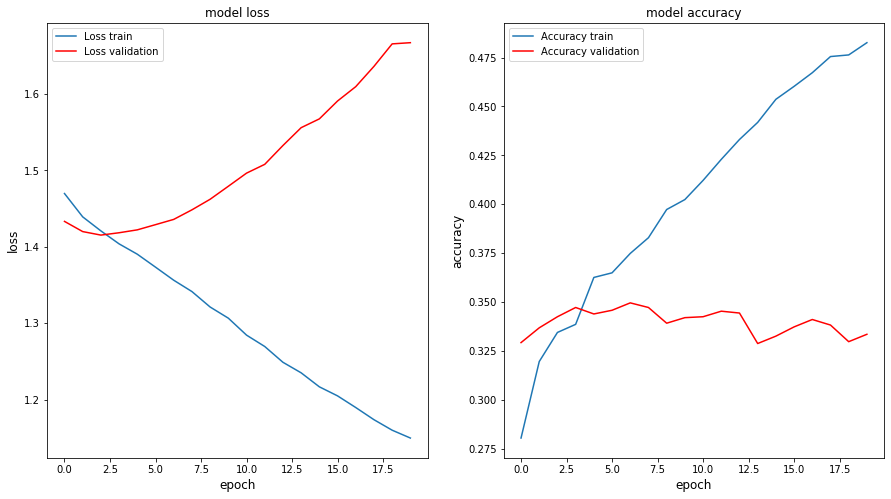

All operations completed
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 24.8488
Function value obtained: 1.0523
Current minimum: 1.0433
Iteration No: 18 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 497
	 hidden_layer_size_2 445
	 hidden_layer_size_3 286
	 learning_rate 0.000419655427126555
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 3s 17ms/step - loss: 1.4724 - accuracy: 0.2788 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 7ms/step - loss: 1.4475 - accuracy: 0.3066 - val_loss: 1.4284 - val_accuracy: 0.3359
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4335 - accuracy: 0.3219 - val_loss: 1.4215 - val_accuracy: 0.3373
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - 

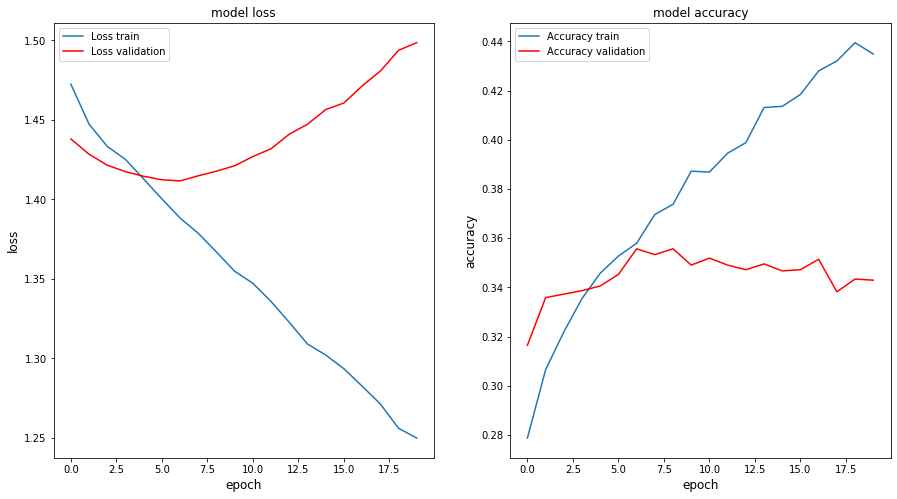

All operations completed
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 25.3165
Function value obtained: 1.1867
Current minimum: 1.0433
Iteration No: 19 started. Searching for the next optimal point.
	 batch_size 109
	 hidden_layer_size_1 25
	 hidden_layer_size_2 35
	 hidden_layer_size_3 481
	 learning_rate 0.000979297379167875
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
78/78 [==============================] - 2s 20ms/step - loss: 1.5109 - accuracy: 0.2697 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
78/78 [==============================] - 0s 6ms/step - loss: 1.4831 - accuracy: 0.2767 - val_loss: 1.4507 - val_accuracy: 0.3089
Epoch 3/20
78/78 [==============================] - 1s 7ms/step - loss: 1.4745 - accuracy: 0.2808 - val_loss: 1.4445 - val_accuracy: 0.3160
Epoch 4/20
78/78 [==============================] - 1s 7ms/step - loss: 1.4

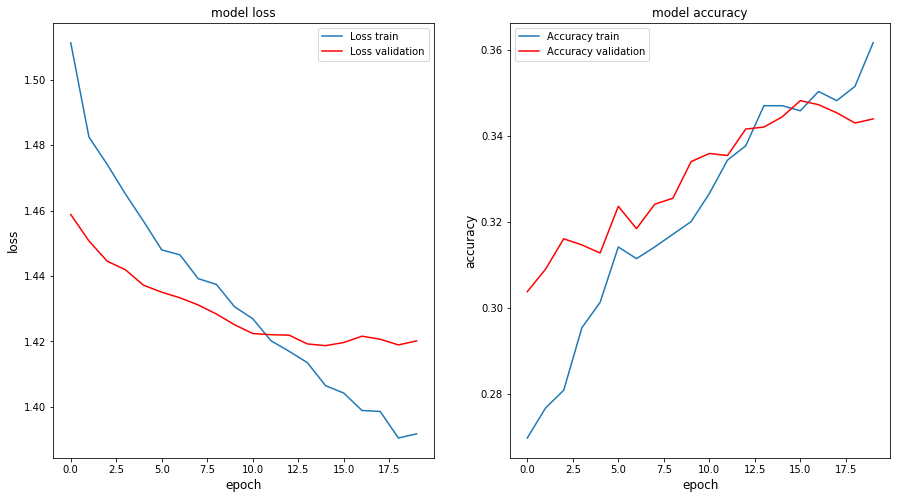

All operations completed
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 13.3488
Function value obtained: 1.3548
Current minimum: 1.0433
Iteration No: 20 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 500
	 hidden_layer_size_2 500
	 hidden_layer_size_3 20
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 3s 16ms/step - loss: 1.4681 - accuracy: 0.2885 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4377 - accuracy: 0.3157 - val_loss: 1.4192 - val_accuracy: 0.3420
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4214 - accuracy: 0.3373 - val_loss: 1.4159 - val_accuracy: 0.3429
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4058 - a

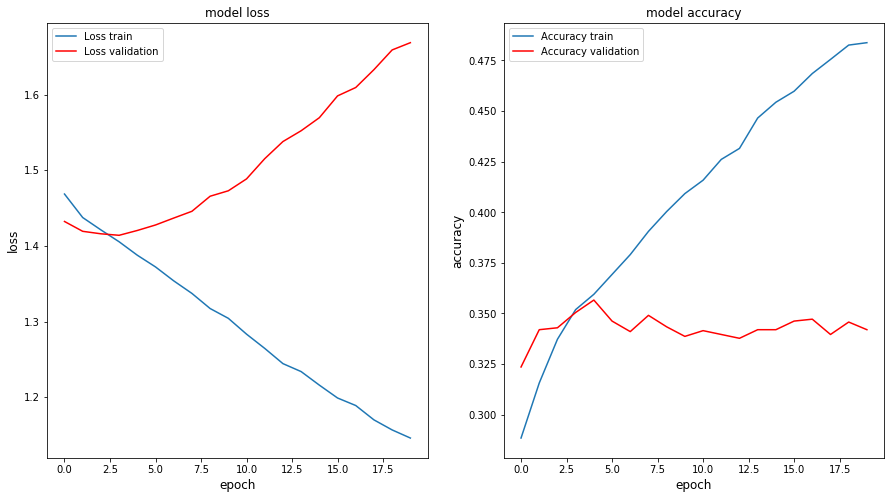

All operations completed
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 25.2090
Function value obtained: 1.0511
Current minimum: 1.0433


In [0]:
dataset, dev_dataset, test_dataset = load_dataset()
nlabels = dataset[TARGET_COL].unique().shape[0]

# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2','State']
}
# Relabel state columns

print(embedded_columns)

numeric_columns = ['Age', 'Fee']
iterations = 20
# TODO (optional) put these three types of columns in the same dictionary with "column types"
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
direct_features_input_shape = (X_train['direct_features'].shape[1],)
X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state=21, verbose=1, n_calls=iterations)

### Search param hidden layer 10-100

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Iteration No: 1 started. Evaluating function at random point.
	 batch_size 130
	 hidden_layer_size_1 71
	 hidden_layer_size_2 13
	 hidden_layer_size_3 96
	 learning_rate 0.00024851120302176203
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
66/66 [==============================] - 2s 23ms/step - loss: 1.6430 - accuracy: 0.1967 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
66/66 [==============================] - 0s 7ms/step - loss: 1.5860 - accuracy: 0.2429 - val_loss: 1.5635 - val_accuracy: 0.2806
Epoch 3/20
66/66 [==============================] - 0s 7ms/step - loss: 1.5667 - accuracy: 0.2543 - val_loss: 1.5417 - val_accuracy: 0.2820
Epoch 4/20
66/66 [==============================] - 0s 7ms/step - loss: 1.5499 - accuracy: 0.2608 - val_loss: 1.5236 - val_accuracy: 0.2863
Epoch 5/20
66/66 [==

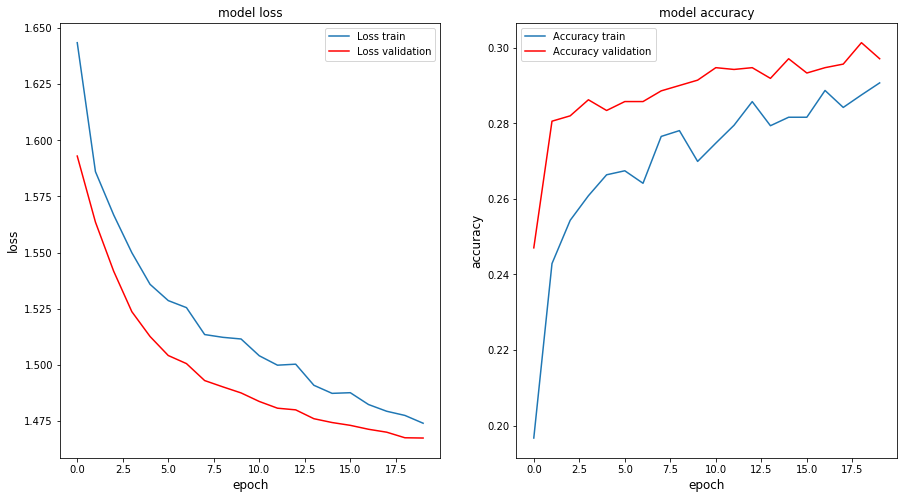

All operations completed
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.3403
Function value obtained: 1.4378
Current minimum: 1.4378
Iteration No: 2 started. Evaluating function at random point.
	 batch_size 66
	 hidden_layer_size_1 86
	 hidden_layer_size_2 41
	 hidden_layer_size_3 84
	 learning_rate 2.23543231654678e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
129/129 [==============================] - 2s 16ms/step - loss: 1.6197 - accuracy: 0.2258 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
129/129 [==============================] - 1s 6ms/step - loss: 1.6008 - accuracy: 0.2444 - val_loss: 1.5818 - val_accuracy: 0.2669
Epoch 3/20
129/129 [==============================] - 1s 6ms/step - loss: 1.5899 - accuracy: 0.2522 - val_loss: 1.5693 - val_accuracy: 0.2735
Epoch 4/20
129/129 [==============================] - 1s 6ms/step - loss: 1.5770 - ac

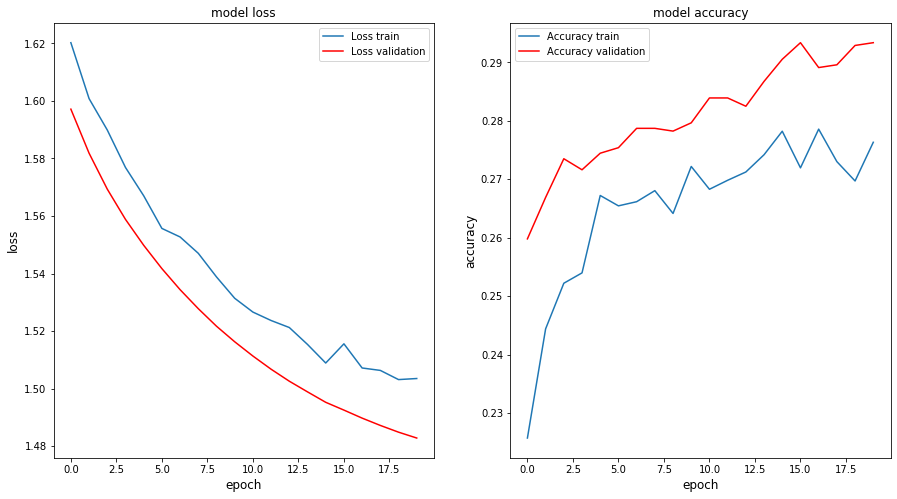

All operations completed
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.1848
Function value obtained: 1.4715
Current minimum: 1.4378
Iteration No: 3 started. Evaluating function at random point.
	 batch_size 96
	 hidden_layer_size_1 19
	 hidden_layer_size_2 79
	 hidden_layer_size_3 44
	 learning_rate 7.103278792699526e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
89/89 [==============================] - 2s 25ms/step - loss: 1.6140 - accuracy: 0.2143 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
89/89 [==============================] - 1s 7ms/step - loss: 1.5936 - accuracy: 0.2302 - val_loss: 1.5789 - val_accuracy: 0.2338
Epoch 3/20
89/89 [==============================] - 1s 7ms/step - loss: 1.5725 - accuracy: 0.2520 - val_loss: 1.5576 - val_accuracy: 0.2678
Epoch 4/20
89/89 [==============================] - 1s 7ms/step - loss: 1.5550 - accuracy:

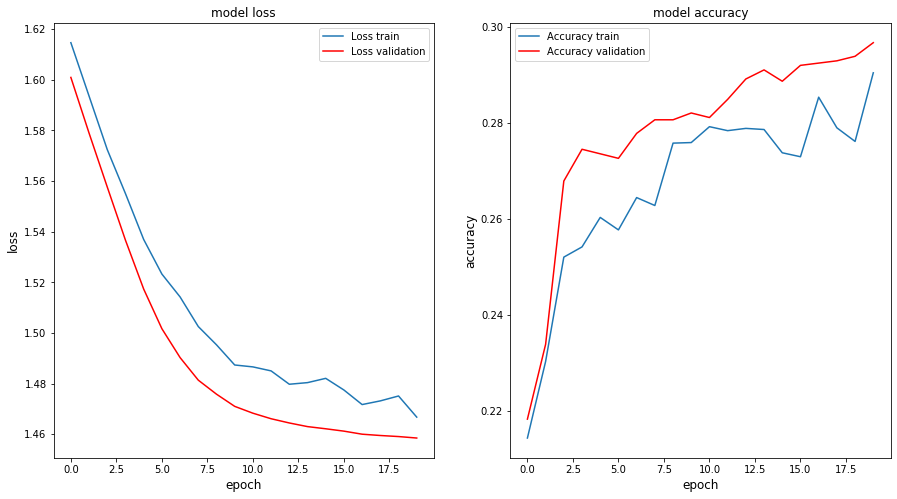

All operations completed
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.9606
Function value obtained: 1.4460
Current minimum: 1.4378
Iteration No: 4 started. Evaluating function at random point.
	 batch_size 147
	 hidden_layer_size_1 35
	 hidden_layer_size_2 62
	 hidden_layer_size_3 55
	 learning_rate 3.8205733833214285e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
58/58 [==============================] - 2s 26ms/step - loss: 1.6173 - accuracy: 0.2266 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
58/58 [==============================] - 0s 7ms/step - loss: 1.6090 - accuracy: 0.2314 - val_loss: 1.5959 - val_accuracy: 0.2475
Epoch 3/20
58/58 [==============================] - 0s 7ms/step - loss: 1.5996 - accuracy: 0.2402 - val_loss: 1.5866 - val_accuracy: 0.2541
Epoch 4/20
58/58 [==============================] - 0s 7ms/step - loss: 1.5892 - accurac

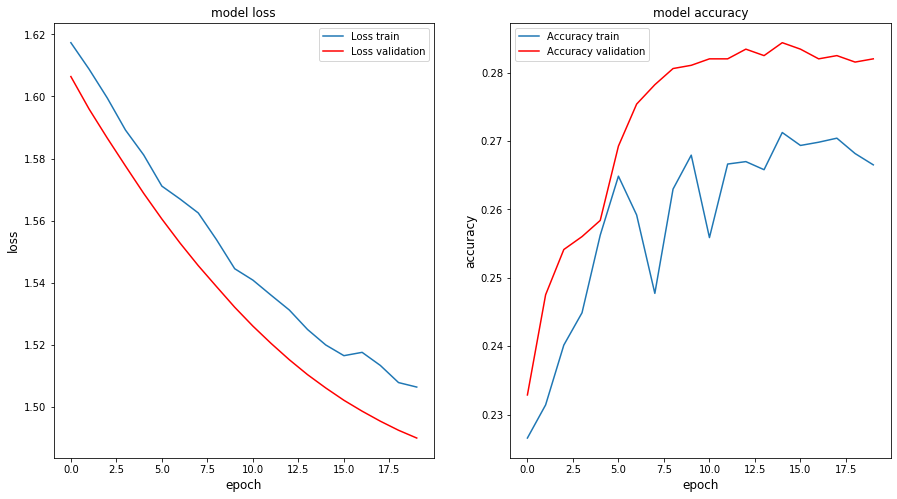

All operations completed
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.4547
Function value obtained: 1.4798
Current minimum: 1.4378
Iteration No: 5 started. Evaluating function at random point.
	 batch_size 107
	 hidden_layer_size_1 89
	 hidden_layer_size_2 93
	 hidden_layer_size_3 96
	 learning_rate 3.8504828866809955e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
80/80 [==============================] - 2s 26ms/step - loss: 1.6436 - accuracy: 0.1654 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
80/80 [==============================] - 1s 7ms/step - loss: 1.6105 - accuracy: 0.2275 - val_loss: 1.5889 - val_accuracy: 0.2584
Epoch 3/20
80/80 [==============================] - 0s 6ms/step - loss: 1.5887 - accuracy: 0.2560 - val_loss: 1.5694 - val_accuracy: 0.2707
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 1.5749 - accurac

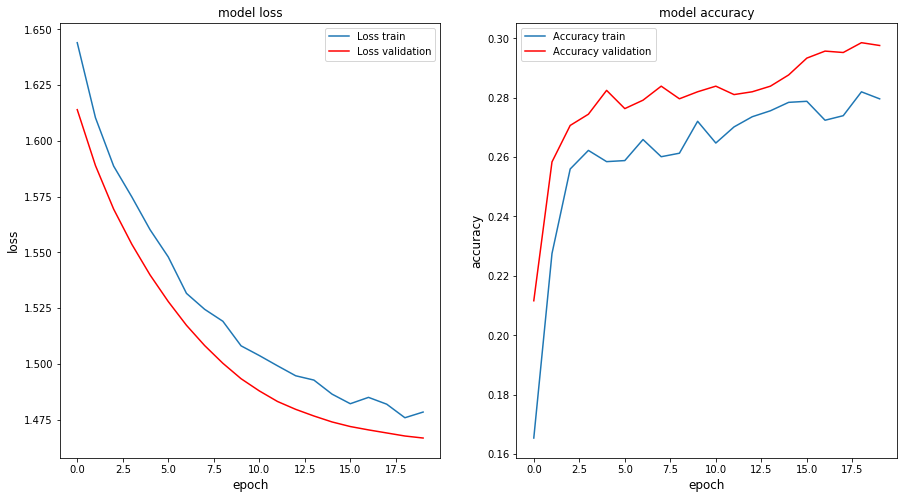

All operations completed
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.2967
Function value obtained: 1.4501
Current minimum: 1.4378
Iteration No: 6 started. Evaluating function at random point.
	 batch_size 73
	 hidden_layer_size_1 34
	 hidden_layer_size_2 18
	 hidden_layer_size_3 78
	 learning_rate 5.899656580061398e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
116/116 [==============================] - 2s 18ms/step - loss: 1.6590 - accuracy: 0.1347 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 1s 7ms/step - loss: 1.6187 - accuracy: 0.1849 - val_loss: 1.5956 - val_accuracy: 0.2197
Epoch 3/20
116/116 [==============================] - 1s 7ms/step - loss: 1.5965 - accuracy: 0.2141 - val_loss: 1.5733 - val_accuracy: 0.2390
Epoch 4/20
116/116 [==============================] - 1s 7ms/step - loss: 1.5776 - a

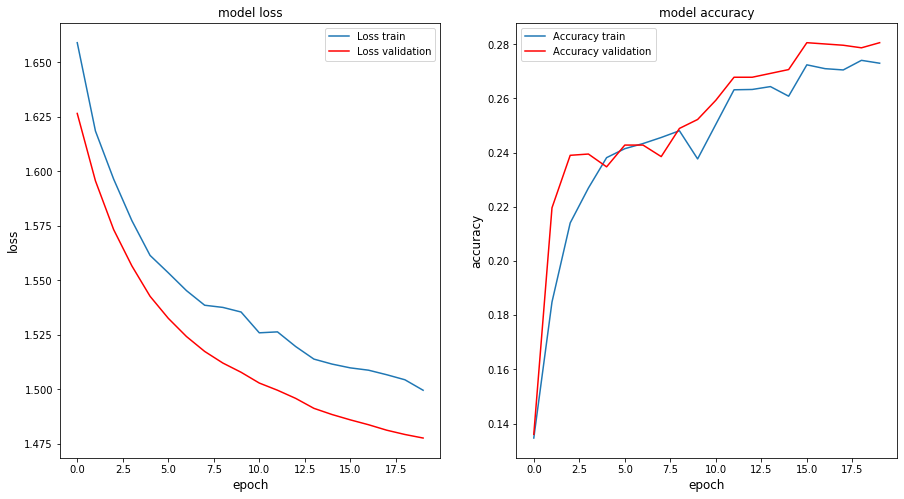

All operations completed
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.7896
Function value obtained: 1.4678
Current minimum: 1.4378
Iteration No: 7 started. Evaluating function at random point.
	 batch_size 111
	 hidden_layer_size_1 25
	 hidden_layer_size_2 46
	 hidden_layer_size_3 82
	 learning_rate 0.0001207316841183635
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
77/77 [==============================] - 2s 21ms/step - loss: 1.5893 - accuracy: 0.2390 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
77/77 [==============================] - 0s 6ms/step - loss: 1.5621 - accuracy: 0.2503 - val_loss: 1.5341 - val_accuracy: 0.2796
Epoch 3/20
77/77 [==============================] - 1s 7ms/step - loss: 1.5391 - accuracy: 0.2646 - val_loss: 1.5120 - val_accuracy: 0.2872
Epoch 4/20
77/77 [==============================] - 1s 7ms/step - loss: 1.5224 - accuracy

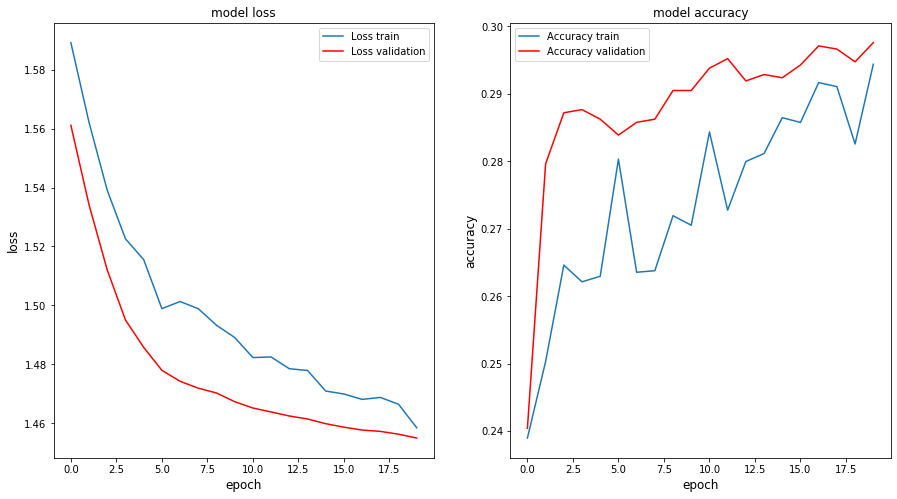

All operations completed
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.7352
Function value obtained: 1.4375
Current minimum: 1.4375
Iteration No: 8 started. Evaluating function at random point.
	 batch_size 126
	 hidden_layer_size_1 46
	 hidden_layer_size_2 82
	 hidden_layer_size_3 86
	 learning_rate 1.4608238804985995e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
68/68 [==============================] - 2s 30ms/step - loss: 1.6286 - accuracy: 0.2012 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
68/68 [==============================] - 0s 7ms/step - loss: 1.6210 - accuracy: 0.2165 - val_loss: 1.6040 - val_accuracy: 0.2362
Epoch 3/20
68/68 [==============================] - 0s 7ms/step - loss: 1.6131 - accuracy: 0.2269 - val_loss: 1.5987 - val_accuracy: 0.2414
Epoch 4/20
68/68 [==============================] - 0s 7ms/step - loss: 1.6132 - accurac

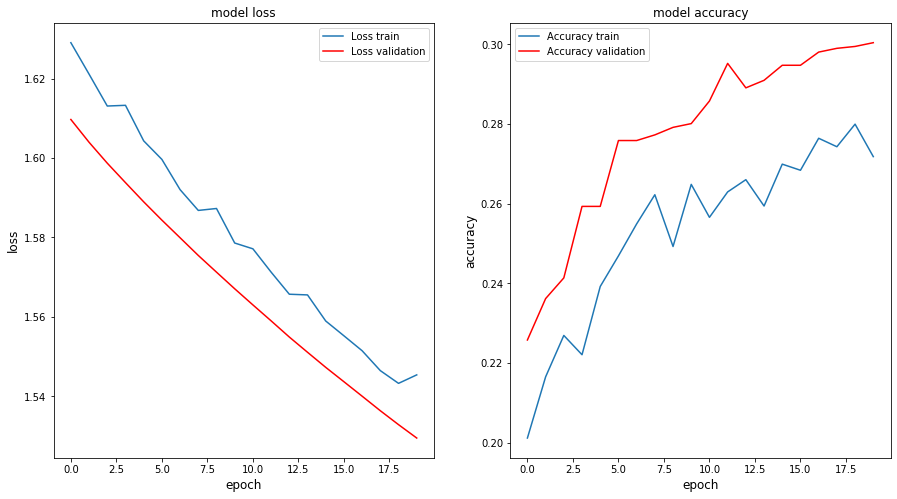

All operations completed
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.0613
Function value obtained: 1.5261
Current minimum: 1.4375
Iteration No: 9 started. Evaluating function at random point.
	 batch_size 144
	 hidden_layer_size_1 57
	 hidden_layer_size_2 65
	 hidden_layer_size_3 78
	 learning_rate 2.6988380143428105e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
59/59 [==============================] - 2s 26ms/step - loss: 1.6589 - accuracy: 0.1503 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 1.6432 - accuracy: 0.1718 - val_loss: 1.6179 - val_accuracy: 0.1894
Epoch 3/20
59/59 [==============================] - 0s 7ms/step - loss: 1.6250 - accuracy: 0.1956 - val_loss: 1.6053 - val_accuracy: 0.2168
Epoch 4/20
59/59 [==============================] - 0s 7ms/step - loss: 1.6162 - accurac

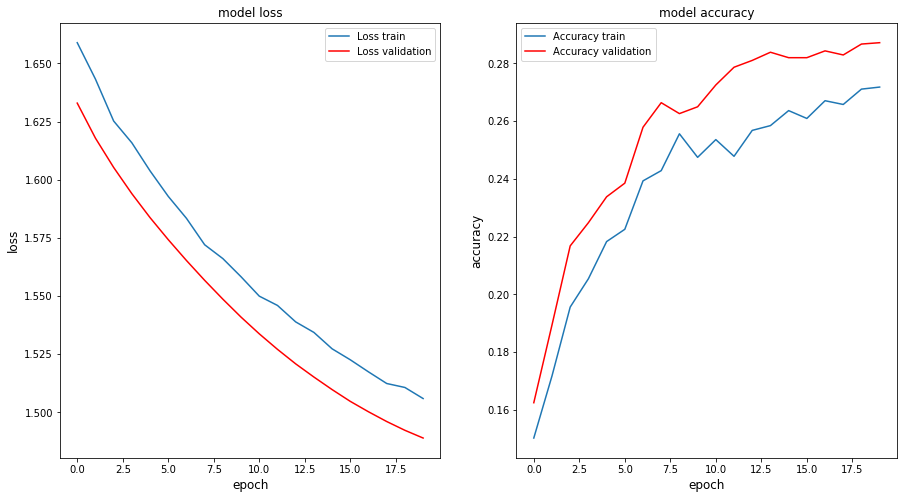

All operations completed
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 10.4060
Function value obtained: 1.4832
Current minimum: 1.4375
Iteration No: 10 started. Evaluating function at random point.
	 batch_size 139
	 hidden_layer_size_1 79
	 hidden_layer_size_2 48
	 hidden_layer_size_3 85
	 learning_rate 1.141812796139562e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
61/61 [==============================] - 1s 25ms/step - loss: 1.6249 - accuracy: 0.2082 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
61/61 [==============================] - 0s 7ms/step - loss: 1.6189 - accuracy: 0.2125 - val_loss: 1.6124 - val_accuracy: 0.2282
Epoch 3/20
61/61 [==============================] - 0s 7ms/step - loss: 1.6177 - accuracy: 0.2135 - val_loss: 1.6083 - val_accuracy: 0.2329
Epoch 4/20
61/61 [==============================] - 0s 7ms/step - loss: 1.6108 - accurac

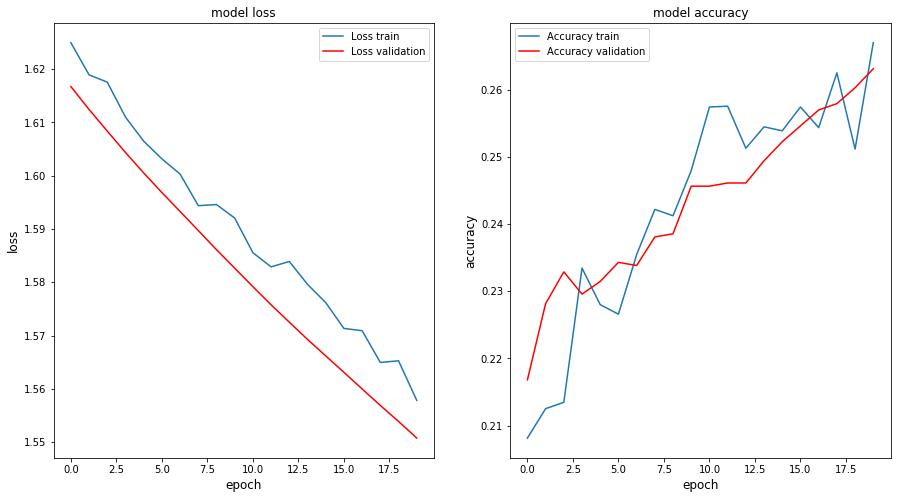

All operations completed
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.5881
Function value obtained: 1.5460
Current minimum: 1.4375
Iteration No: 11 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.00016733330784959895
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 3s 17ms/step - loss: 1.5765 - accuracy: 0.2352 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4905 - accuracy: 0.2829 - val_loss: 1.4707 - val_accuracy: 0.2877
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4735 - accuracy: 0.2823 - val_loss: 1.4650 - val_accuracy: 0.3037
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.46

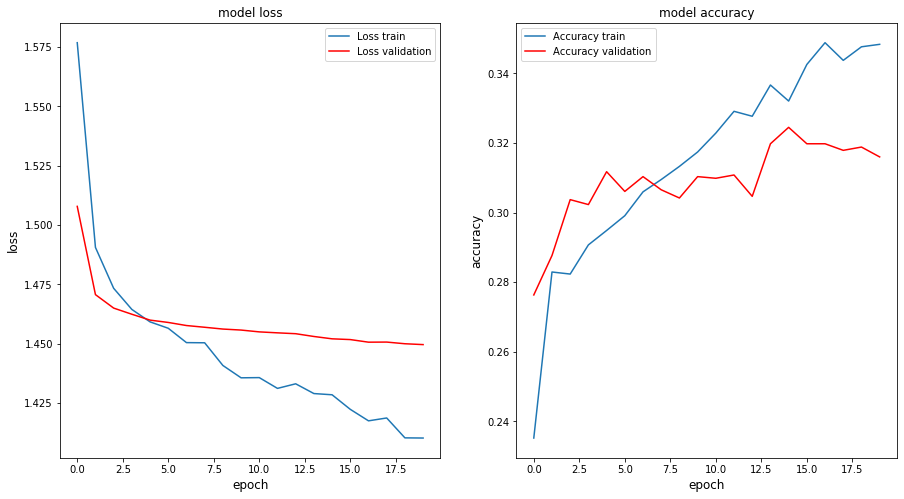

All operations completed
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 25.4597
Function value obtained: 1.3888
Current minimum: 1.3888
Iteration No: 12 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4888 - accuracy: 0.2724 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4513 - accuracy: 0.3022 - val_loss: 1.4588 - val_accuracy: 0.3061
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4377 - accuracy: 0.3180 - val_loss: 1.4535 - val_accuracy: 0.3127
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4247 - a

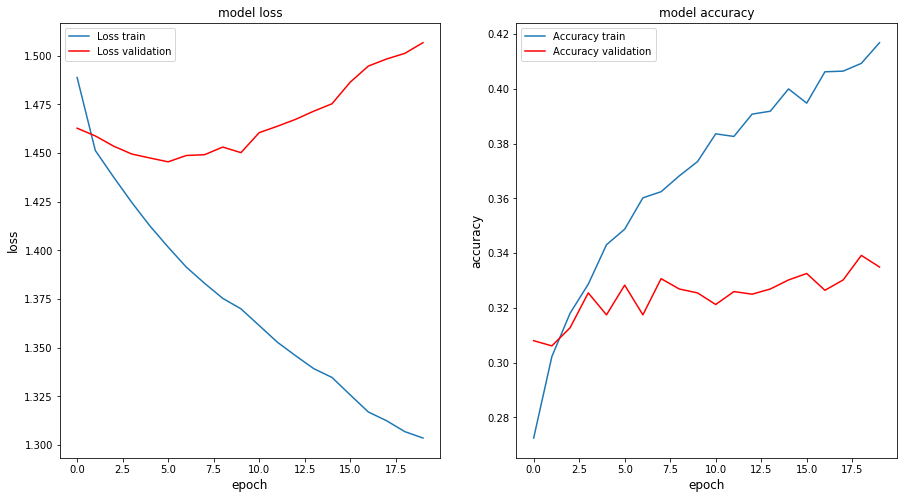

All operations completed
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 25.1688
Function value obtained: 1.2531
Current minimum: 1.2531
Iteration No: 13 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.5001 - accuracy: 0.2594 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4586 - accuracy: 0.2911 - val_loss: 1.4582 - val_accuracy: 0.3066
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4462 - accuracy: 0.2990 - val_loss: 1.4550 - val_accuracy: 0.3070
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4377 - a

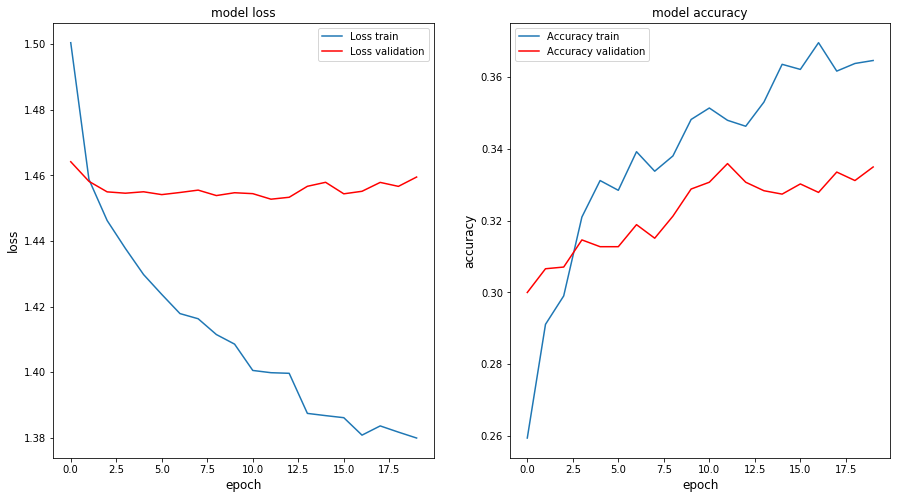

All operations completed
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 24.7708
Function value obtained: 1.3511
Current minimum: 1.2531
Iteration No: 14 started. Searching for the next optimal point.
	 batch_size 150
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
57/57 [==============================] - 2s 34ms/step - loss: 1.5305 - accuracy: 0.2535 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 0s 7ms/step - loss: 1.4756 - accuracy: 0.2671 - val_loss: 1.4655 - val_accuracy: 0.3004
Epoch 3/20
57/57 [==============================] - 0s 7ms/step - loss: 1.4602 - accuracy: 0.2916 - val_loss: 1.4614 - val_accuracy: 0.2990
Epoch 4/20
57/57 [==============================] - 0s 7ms/step - loss: 1.4530 - accuracy:

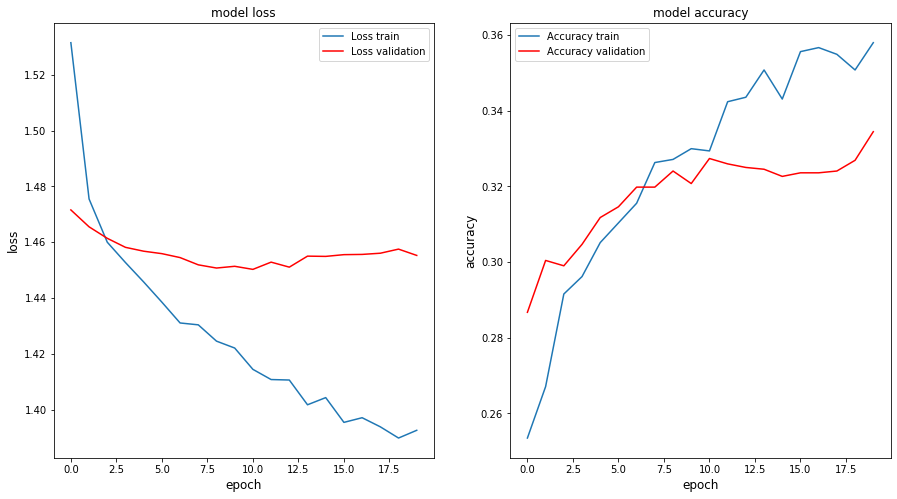

All operations completed
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.3919
Function value obtained: 1.3650
Current minimum: 1.2531
Iteration No: 15 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 10
	 hidden_layer_size_3 99
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.5369 - accuracy: 0.2561 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4977 - accuracy: 0.2620 - val_loss: 1.4679 - val_accuracy: 0.2976
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4764 - accuracy: 0.2861 - val_loss: 1.4588 - val_accuracy: 0.3047
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4636 - ac

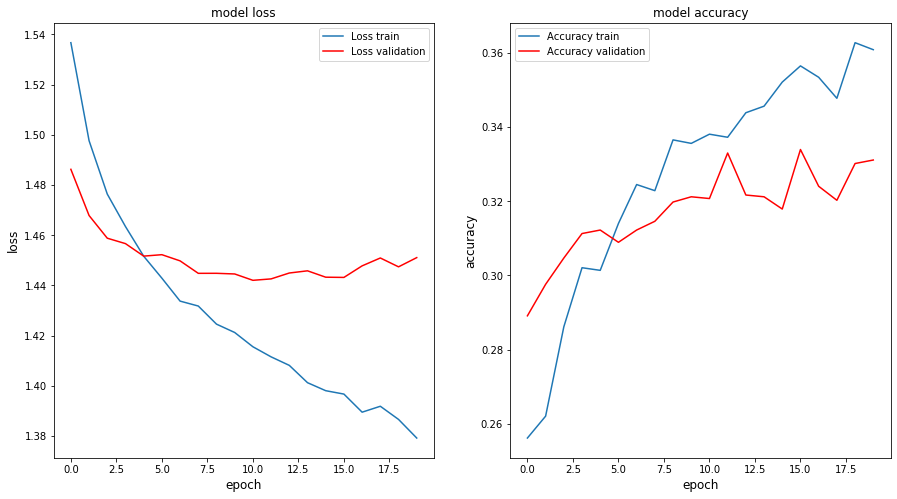

All operations completed
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 25.0630
Function value obtained: 1.3450
Current minimum: 1.2531
Iteration No: 16 started. Searching for the next optimal point.
	 batch_size 70
	 hidden_layer_size_1 100
	 hidden_layer_size_2 10
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
121/121 [==============================] - 2s 17ms/step - loss: 1.5653 - accuracy: 0.2612 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
121/121 [==============================] - 1s 7ms/step - loss: 1.5023 - accuracy: 0.2826 - val_loss: 1.4706 - val_accuracy: 0.2966
Epoch 3/20
121/121 [==============================] - 1s 6ms/step - loss: 1.4743 - accuracy: 0.2981 - val_loss: 1.4603 - val_accuracy: 0.3070
Epoch 4/20
121/121 [==============================] - 1s 6ms/step - loss: 1.4584 - ac

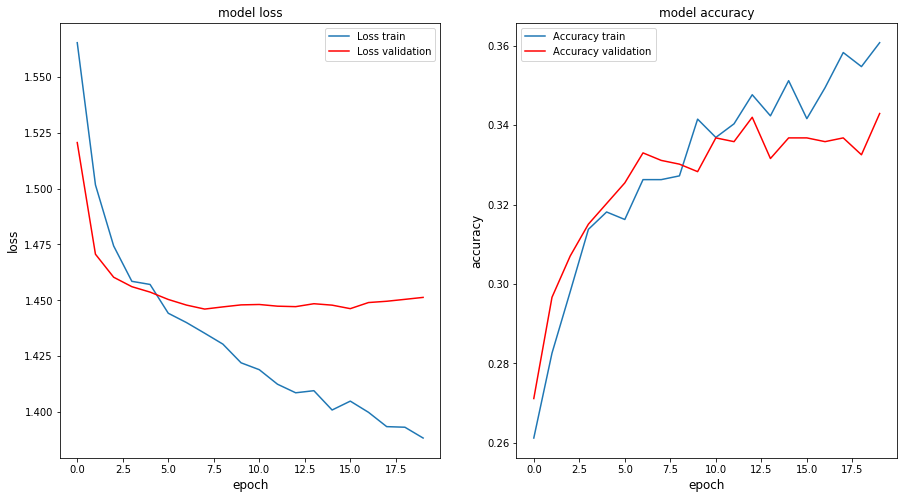

All operations completed
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 19.5089
Function value obtained: 1.3540
Current minimum: 1.2531
Iteration No: 17 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4898 - accuracy: 0.2611 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4531 - accuracy: 0.3035 - val_loss: 1.4568 - val_accuracy: 0.3160
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4384 - accuracy: 0.3237 - val_loss: 1.4513 - val_accuracy: 0.3170
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4269 - 

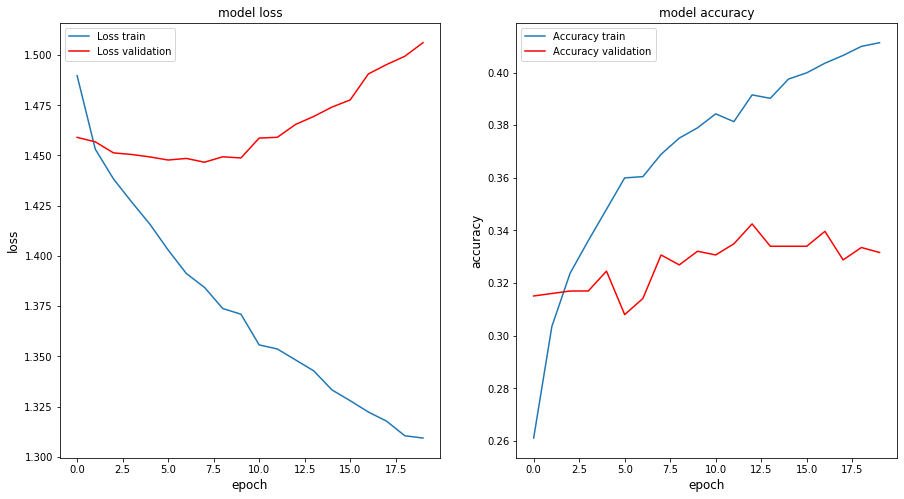

All operations completed
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 25.1545
Function value obtained: 1.2539
Current minimum: 1.2531
Iteration No: 18 started. Searching for the next optimal point.
	 batch_size 58
	 hidden_layer_size_1 94
	 hidden_layer_size_2 99
	 hidden_layer_size_3 40
	 learning_rate 0.0006502001060094471
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
146/146 [==============================] - 2s 15ms/step - loss: 1.5019 - accuracy: 0.2651 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
146/146 [==============================] - 1s 6ms/step - loss: 1.4574 - accuracy: 0.3006 - val_loss: 1.4570 - val_accuracy: 0.3137
Epoch 3/20
146/146 [==============================] - 1s 6ms/step - loss: 1.4466 - accuracy: 0.3061 - val_loss: 1.4547 - val_accuracy: 0.3231
Epoch 4/20
146/146 [==============================] - 1s 6ms/step - lo

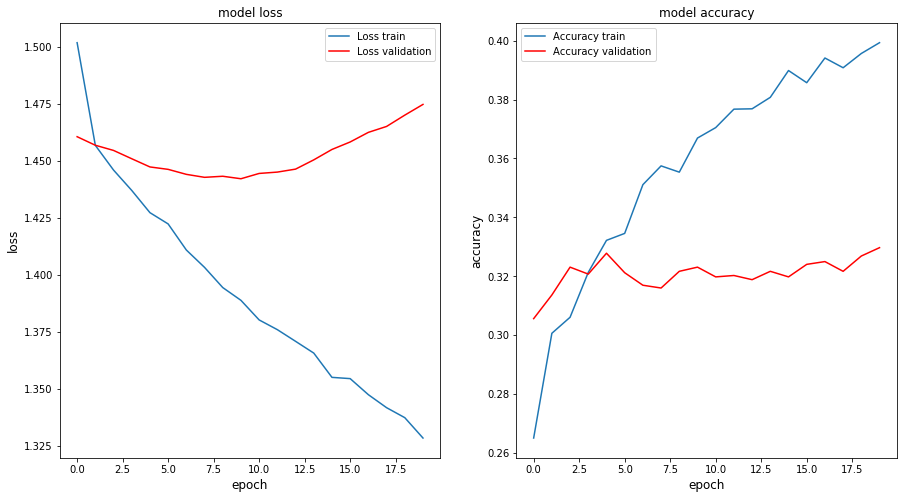

All operations completed
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 22.0144
Function value obtained: 1.2908
Current minimum: 1.2531
Iteration No: 19 started. Searching for the next optimal point.
	 batch_size 130
	 hidden_layer_size_1 77
	 hidden_layer_size_2 100
	 hidden_layer_size_3 86
	 learning_rate 0.000969337424520551
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
66/66 [==============================] - 2s 31ms/step - loss: 1.5015 - accuracy: 0.2662 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
66/66 [==============================] - 0s 7ms/step - loss: 1.4641 - accuracy: 0.2917 - val_loss: 1.4571 - val_accuracy: 0.3132
Epoch 3/20
66/66 [==============================] - 0s 7ms/step - loss: 1.4519 - accuracy: 0.3048 - val_loss: 1.4549 - val_accuracy: 0.3108
Epoch 4/20
66/66 [==============================] - 0s 6ms/step - loss: 1.4

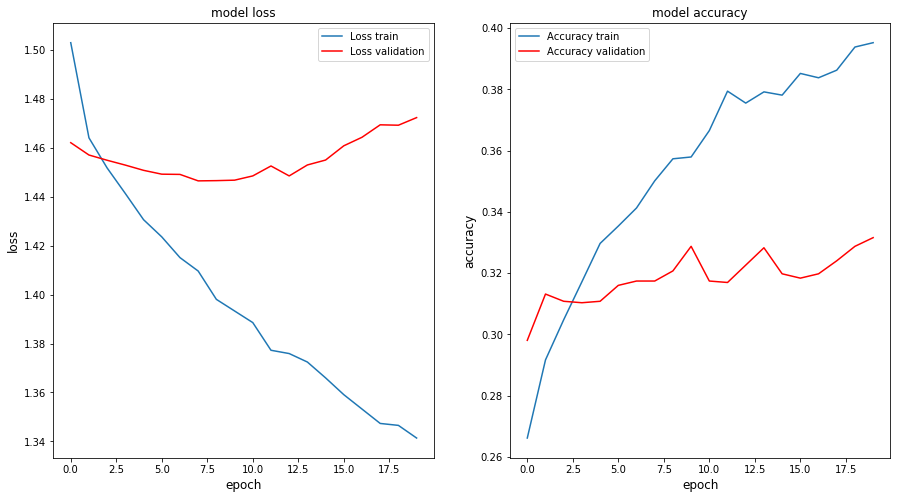

All operations completed
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 12.4077
Function value obtained: 1.3030
Current minimum: 1.2531
Iteration No: 20 started. Searching for the next optimal point.
	 batch_size 148
	 hidden_layer_size_1 100
	 hidden_layer_size_2 89
	 hidden_layer_size_3 35
	 learning_rate 0.0009080327607128191
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
58/58 [==============================] - 1s 26ms/step - loss: 1.5065 - accuracy: 0.2701 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
58/58 [==============================] - 0s 7ms/step - loss: 1.4636 - accuracy: 0.2894 - val_loss: 1.4570 - val_accuracy: 0.3056
Epoch 3/20
58/58 [==============================] - 0s 7ms/step - loss: 1.4524 - accuracy: 0.3086 - val_loss: 1.4535 - val_accuracy: 0.3141
Epoch 4/20
58/58 [==============================] - 0s 7ms/step - loss: 1.

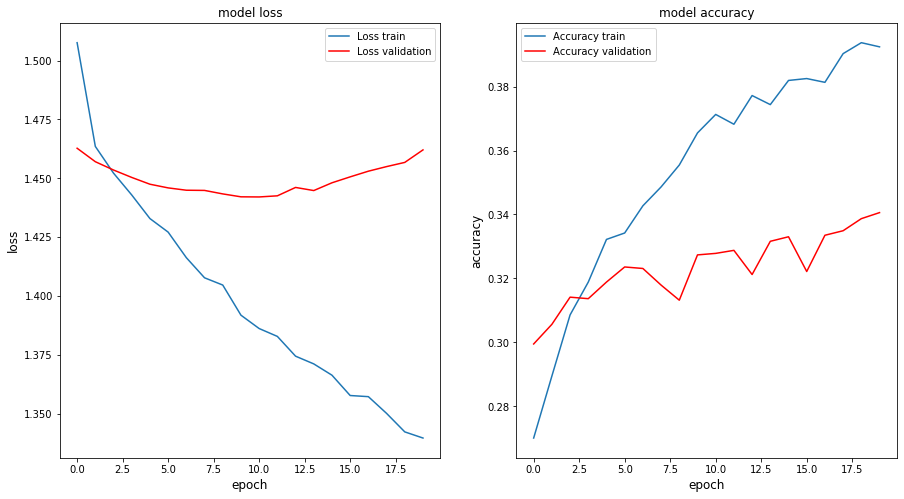

All operations completed
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.9835
Function value obtained: 1.3012
Current minimum: 1.2531


In [0]:
dataset, dev_dataset, test_dataset = load_dataset()
nlabels = dataset[TARGET_COL].unique().shape[0]

# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2','State']
}
# Relabel state columns

print(embedded_columns)

numeric_columns = ['Age', 'Fee']
iterations = 20
# TODO (optional) put these three types of columns in the same dictionary with "column types"
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
direct_features_input_shape = (X_train['direct_features'].shape[1],)
X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state=21, verbose=1, n_calls=iterations)

### Search param batch size 50 a 100

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Iteration No: 1 started. Evaluating function at random point.
	 batch_size 90
	 hidden_layer_size_1 71
	 hidden_layer_size_2 13
	 hidden_layer_size_3 96
	 learning_rate 0.00024851120302176203
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
95/95 [==============================] - 2s 19ms/step - loss: 1.5567 - accuracy: 0.2693 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
95/95 [==============================] - 1s 6ms/step - loss: 1.5301 - accuracy: 0.2745 - val_loss: 1.4924 - val_accuracy: 0.2839
Epoch 3/20
95/95 [==============================] - 1s 6ms/step - loss: 1.5137 - accuracy: 0.2848 - val_loss: 1.4816 - val_accuracy: 0.2872
Epoch 4/20
95/95 [==============================] - 1s 7ms/step - loss: 1.5084 - accuracy: 0.2836 - val_loss: 1.4760 - val_accuracy: 0.2938
Epoch 5/20
95/95 [===

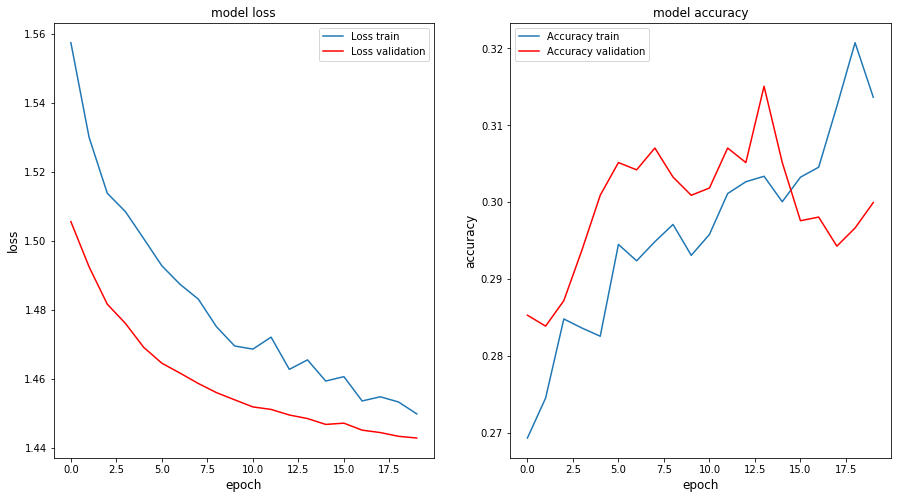

All operations completed
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.0452
Function value obtained: 1.4172
Current minimum: 1.4172
Iteration No: 2 started. Evaluating function at random point.
	 batch_size 58
	 hidden_layer_size_1 86
	 hidden_layer_size_2 41
	 hidden_layer_size_3 84
	 learning_rate 2.23543231654678e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
146/146 [==============================] - 2s 15ms/step - loss: 1.6490 - accuracy: 0.2143 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
146/146 [==============================] - 1s 6ms/step - loss: 1.6248 - accuracy: 0.2425 - val_loss: 1.5959 - val_accuracy: 0.2664
Epoch 3/20
146/146 [==============================] - 1s 6ms/step - loss: 1.6091 - accuracy: 0.2509 - val_loss: 1.5805 - val_accuracy: 0.2664
Epoch 4/20
146/146 [==============================] - 1s 6ms/step - loss: 1.5922 - ac

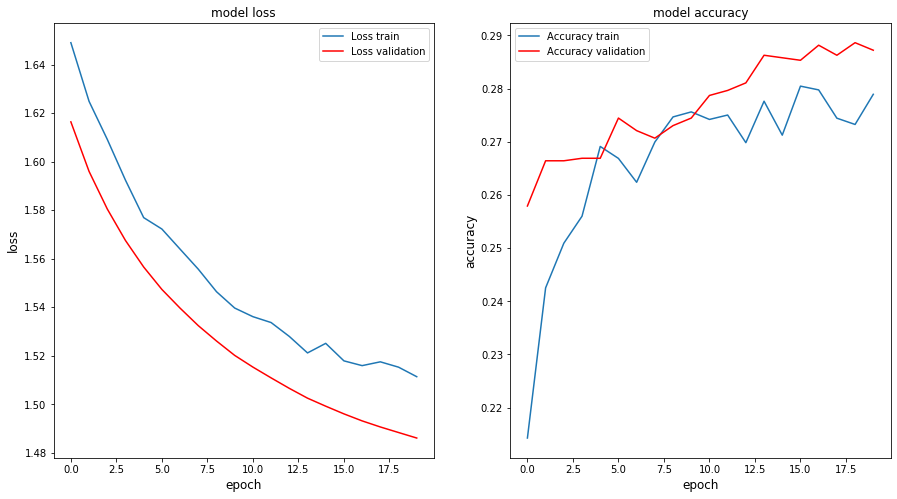

All operations completed
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 21.7482
Function value obtained: 1.4810
Current minimum: 1.4172
Iteration No: 3 started. Evaluating function at random point.
	 batch_size 73
	 hidden_layer_size_1 19
	 hidden_layer_size_2 79
	 hidden_layer_size_3 44
	 learning_rate 7.103278792699526e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
116/116 [==============================] - 2s 17ms/step - loss: 1.6342 - accuracy: 0.1809 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 1s 6ms/step - loss: 1.6039 - accuracy: 0.2223 - val_loss: 1.5868 - val_accuracy: 0.2192
Epoch 3/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5824 - accuracy: 0.2358 - val_loss: 1.5649 - val_accuracy: 0.2381
Epoch 4/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5568 - a

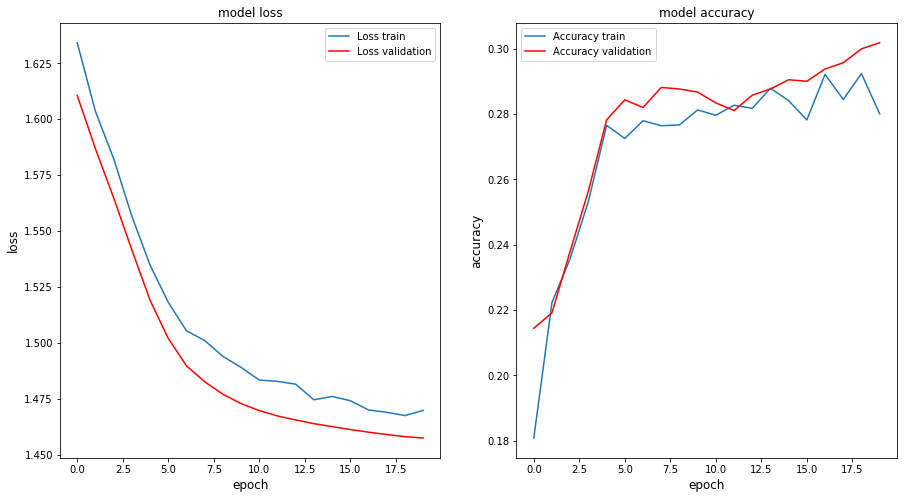

All operations completed
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.8183
Function value obtained: 1.4489
Current minimum: 1.4172
Iteration No: 4 started. Evaluating function at random point.
	 batch_size 98
	 hidden_layer_size_1 35
	 hidden_layer_size_2 62
	 hidden_layer_size_3 55
	 learning_rate 3.8205733833214285e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
87/87 [==============================] - 2s 20ms/step - loss: 1.5946 - accuracy: 0.2408 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
87/87 [==============================] - 1s 7ms/step - loss: 1.5789 - accuracy: 0.2386 - val_loss: 1.5591 - val_accuracy: 0.2400
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 1.5645 - accuracy: 0.2553 - val_loss: 1.5470 - val_accuracy: 0.2456
Epoch 4/20
87/87 [==============================] - 1s 6ms/step - loss: 1.5526 - accuracy

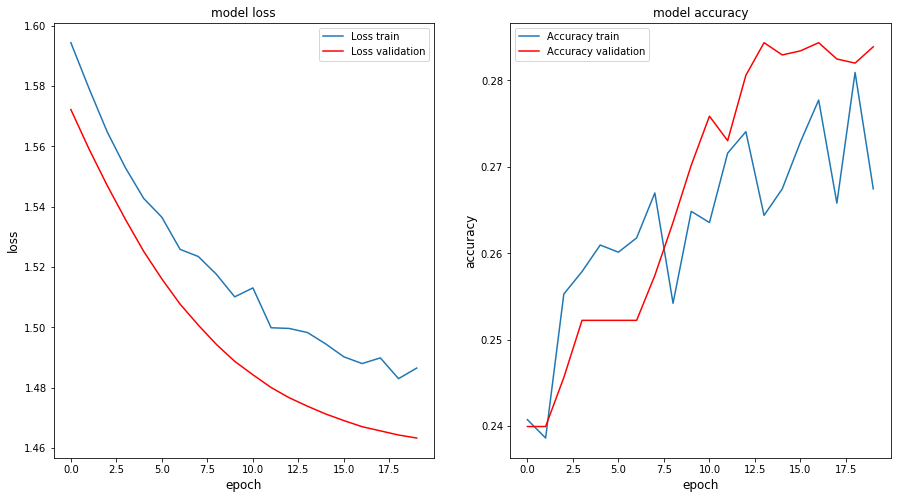

All operations completed
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.1596
Function value obtained: 1.4595
Current minimum: 1.4172
Iteration No: 5 started. Evaluating function at random point.
	 batch_size 78
	 hidden_layer_size_1 89
	 hidden_layer_size_2 93
	 hidden_layer_size_3 96
	 learning_rate 3.8504828866809955e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
109/109 [==============================] - 2s 18ms/step - loss: 1.6072 - accuracy: 0.2258 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
109/109 [==============================] - 1s 6ms/step - loss: 1.5739 - accuracy: 0.2535 - val_loss: 1.5481 - val_accuracy: 0.2617
Epoch 3/20
109/109 [==============================] - 1s 7ms/step - loss: 1.5507 - accuracy: 0.2591 - val_loss: 1.5270 - val_accuracy: 0.2678
Epoch 4/20
109/109 [==============================] - 1s 6ms/step - loss: 1.5325 - 

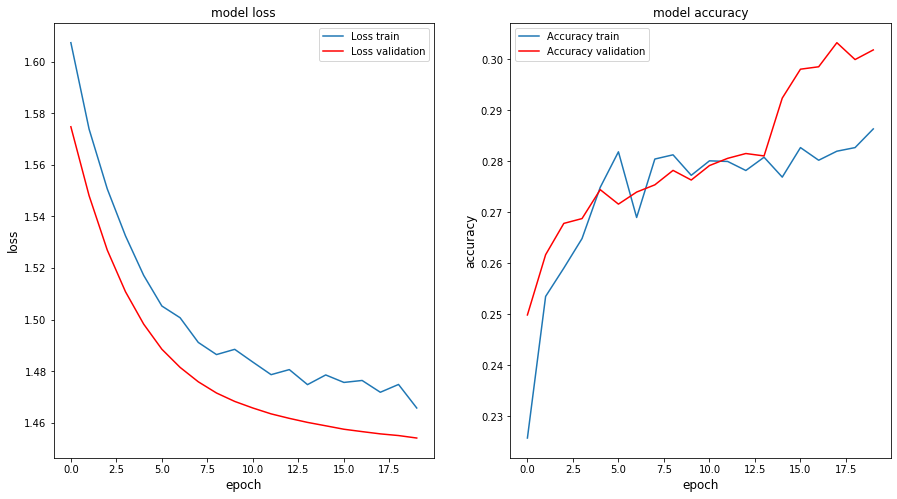

All operations completed
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 16.8462
Function value obtained: 1.4468
Current minimum: 1.4172
Iteration No: 6 started. Evaluating function at random point.
	 batch_size 62
	 hidden_layer_size_1 34
	 hidden_layer_size_2 18
	 hidden_layer_size_3 78
	 learning_rate 5.899656580061398e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
137/137 [==============================] - 3s 20ms/step - loss: 1.6416 - accuracy: 0.2236 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
137/137 [==============================] - 1s 6ms/step - loss: 1.6172 - accuracy: 0.2338 - val_loss: 1.5938 - val_accuracy: 0.2437
Epoch 3/20
137/137 [==============================] - 1s 6ms/step - loss: 1.5981 - accuracy: 0.2343 - val_loss: 1.5831 - val_accuracy: 0.2452
Epoch 4/20
137/137 [==============================] - 1s 6ms/step - loss: 1.5862 - a

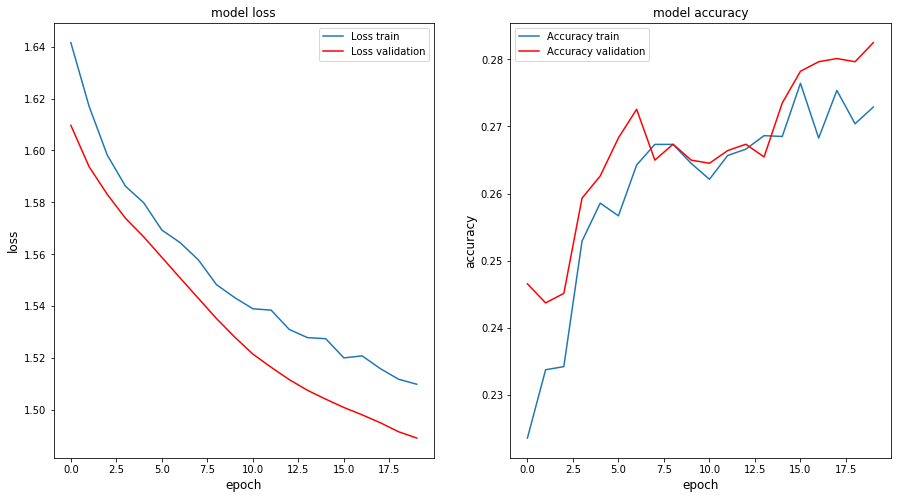

All operations completed
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 21.0080
Function value obtained: 1.4821
Current minimum: 1.4172
Iteration No: 7 started. Evaluating function at random point.
	 batch_size 80
	 hidden_layer_size_1 25
	 hidden_layer_size_2 46
	 hidden_layer_size_3 82
	 learning_rate 0.0001207316841183635
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
106/106 [==============================] - 2s 17ms/step - loss: 1.5984 - accuracy: 0.2189 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5544 - accuracy: 0.2458 - val_loss: 1.5235 - val_accuracy: 0.2593
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5266 - accuracy: 0.2637 - val_loss: 1.4994 - val_accuracy: 0.2622
Epoch 4/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5097 - a

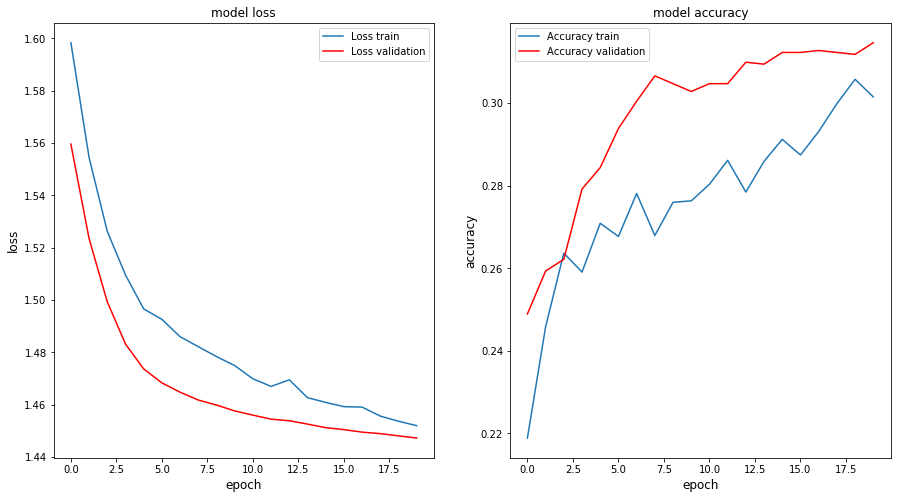

All operations completed
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 16.4934
Function value obtained: 1.4332
Current minimum: 1.4172
Iteration No: 8 started. Evaluating function at random point.
	 batch_size 88
	 hidden_layer_size_1 46
	 hidden_layer_size_2 82
	 hidden_layer_size_3 86
	 learning_rate 1.4608238804985995e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
97/97 [==============================] - 2s 19ms/step - loss: 1.6022 - accuracy: 0.2317 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
97/97 [==============================] - 1s 7ms/step - loss: 1.5925 - accuracy: 0.2398 - val_loss: 1.5770 - val_accuracy: 0.2607
Epoch 3/20
97/97 [==============================] - 1s 7ms/step - loss: 1.5858 - accuracy: 0.2554 - val_loss: 1.5701 - val_accuracy: 0.2664
Epoch 4/20
97/97 [==============================] - 1s 7ms/step - loss: 1.5758 - accuracy

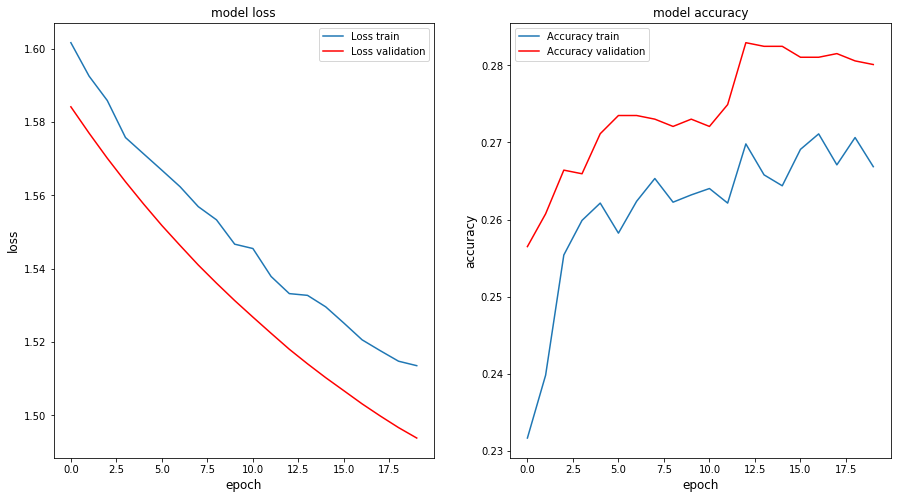

All operations completed
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 15.3827
Function value obtained: 1.4943
Current minimum: 1.4172
Iteration No: 9 started. Evaluating function at random point.
	 batch_size 97
	 hidden_layer_size_1 57
	 hidden_layer_size_2 65
	 hidden_layer_size_3 78
	 learning_rate 2.6988380143428105e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
88/88 [==============================] - 2s 26ms/step - loss: 1.6183 - accuracy: 0.2328 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
88/88 [==============================] - 1s 6ms/step - loss: 1.6018 - accuracy: 0.2434 - val_loss: 1.5775 - val_accuracy: 0.2664
Epoch 3/20
88/88 [==============================] - 1s 6ms/step - loss: 1.5839 - accuracy: 0.2547 - val_loss: 1.5640 - val_accuracy: 0.2683
Epoch 4/20
88/88 [==============================] - 1s 7ms/step - loss: 1.5685 - accuracy

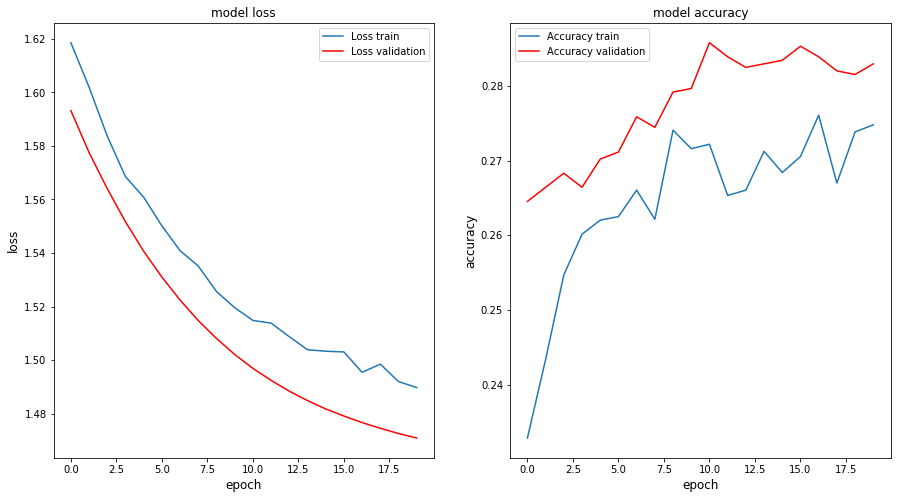

All operations completed
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 14.6168
Function value obtained: 1.4623
Current minimum: 1.4172
Iteration No: 10 started. Evaluating function at random point.
	 batch_size 95
	 hidden_layer_size_1 79
	 hidden_layer_size_2 48
	 hidden_layer_size_3 85
	 learning_rate 1.141812796139562e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
90/90 [==============================] - 2s 19ms/step - loss: 1.6632 - accuracy: 0.1751 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
90/90 [==============================] - 1s 7ms/step - loss: 1.6480 - accuracy: 0.1852 - val_loss: 1.6240 - val_accuracy: 0.2192
Epoch 3/20
90/90 [==============================] - 1s 6ms/step - loss: 1.6417 - accuracy: 0.1940 - val_loss: 1.6151 - val_accuracy: 0.2310
Epoch 4/20
90/90 [==============================] - 1s 6ms/step - loss: 1.6320 - accuracy

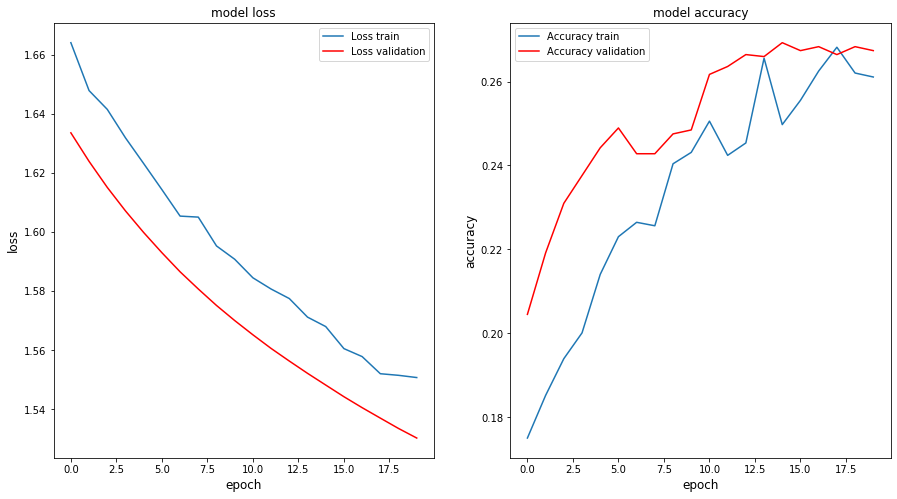

All operations completed
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 14.9245
Function value obtained: 1.5266
Current minimum: 1.4172
Iteration No: 11 started. Searching for the next optimal point.
	 batch_size 88
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 43
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
97/97 [==============================] - 2s 18ms/step - loss: 1.5114 - accuracy: 0.2741 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
97/97 [==============================] - 1s 7ms/step - loss: 1.4756 - accuracy: 0.2803 - val_loss: 1.4539 - val_accuracy: 0.2990
Epoch 3/20
97/97 [==============================] - 1s 7ms/step - loss: 1.4557 - accuracy: 0.2962 - val_loss: 1.4450 - val_accuracy: 0.2995
Epoch 4/20
97/97 [==============================] - 1s 7ms/step - loss: 1.4476 - accuracy: 0.3149 - va

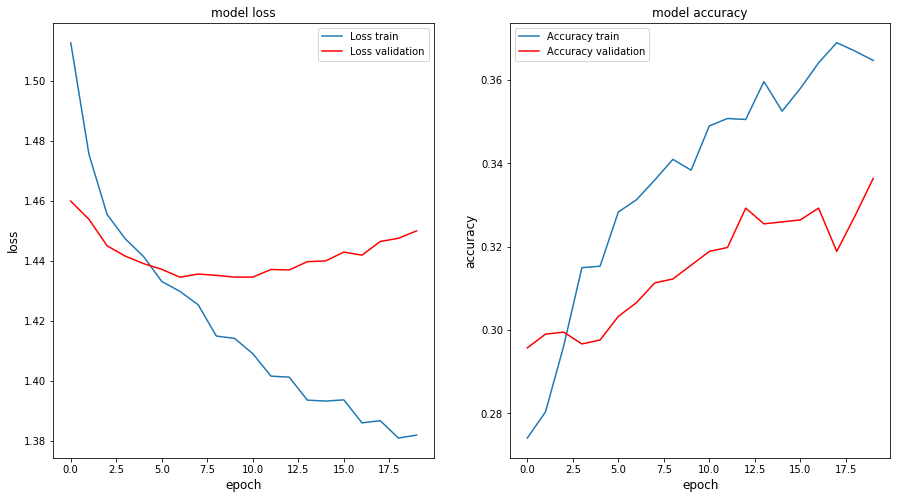

All operations completed
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 16.1082
Function value obtained: 1.3507
Current minimum: 1.3507
Iteration No: 12 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 10
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.5406 - accuracy: 0.2628 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4952 - accuracy: 0.2846 - val_loss: 1.4633 - val_accuracy: 0.3061
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4761 - accuracy: 0.2950 - val_loss: 1.4546 - val_accuracy: 0.3127
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4652 - ac

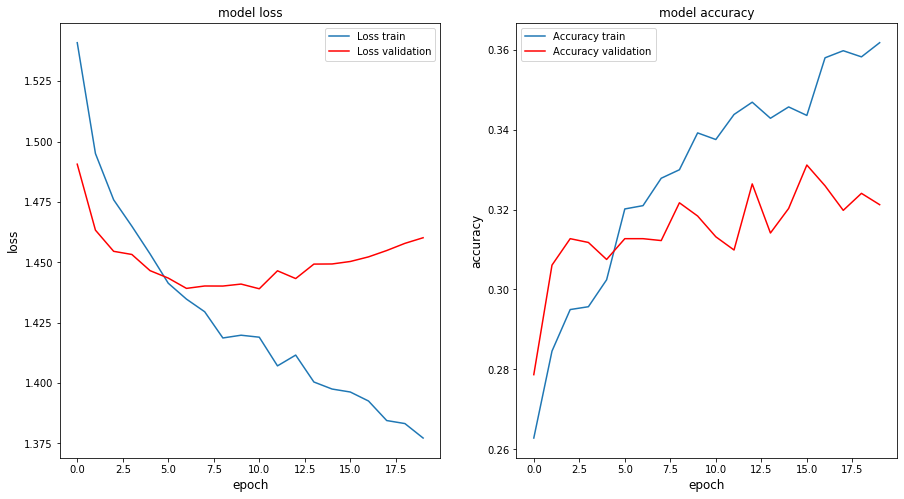

All operations completed
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 25.5453
Function value obtained: 1.3379
Current minimum: 1.3379
Iteration No: 13 started. Searching for the next optimal point.
	 batch_size 53
	 hidden_layer_size_1 67
	 hidden_layer_size_2 100
	 hidden_layer_size_3 22
	 learning_rate 0.00057913459166982
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
160/160 [==============================] - 2s 15ms/step - loss: 1.5045 - accuracy: 0.2710 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
160/160 [==============================] - 1s 6ms/step - loss: 1.4623 - accuracy: 0.2882 - val_loss: 1.4502 - val_accuracy: 0.2957
Epoch 3/20
160/160 [==============================] - 1s 6ms/step - loss: 1.4543 - accuracy: 0.3032 - val_loss: 1.4471 - val_accuracy: 0.3075
Epoch 4/20
160/160 [==============================] - 1s 6ms/step - los

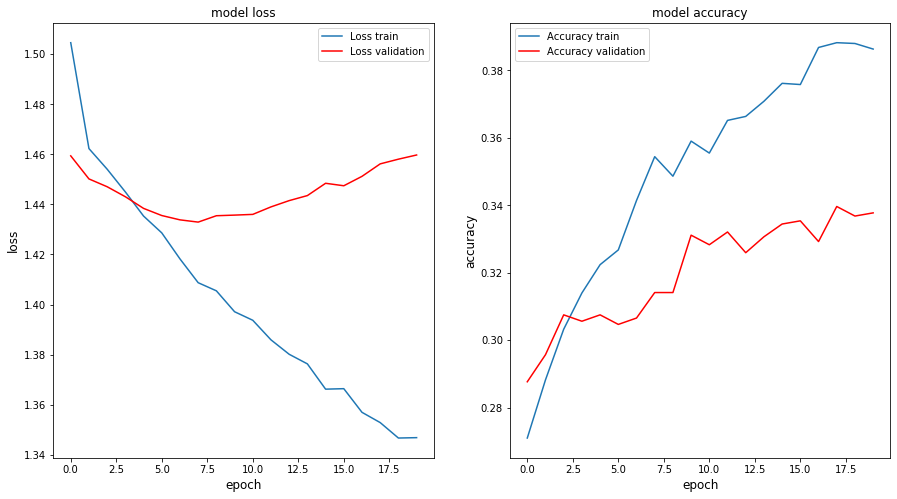

All operations completed
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 23.9927
Function value obtained: 1.3077
Current minimum: 1.3077
Iteration No: 14 started. Searching for the next optimal point.
	 batch_size 51
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.0004212727592650835
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
166/166 [==============================] - 2s 14ms/step - loss: 1.5219 - accuracy: 0.2692 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
166/166 [==============================] - 1s 6ms/step - loss: 1.4781 - accuracy: 0.2717 - val_loss: 1.4614 - val_accuracy: 0.2938
Epoch 3/20
166/166 [==============================] - 1s 6ms/step - loss: 1.4688 - accuracy: 0.2832 - val_loss: 1.4591 - val_accuracy: 0.2877
Epoch 4/20
166/166 [==============================] - 1s 6ms/step - l

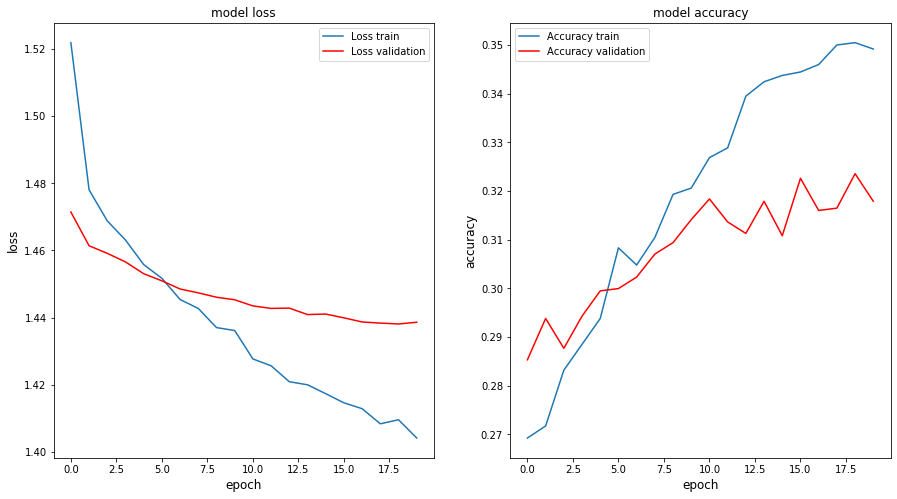

All operations completed
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 24.8168
Function value obtained: 1.3849
Current minimum: 1.3077
Iteration No: 15 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 15ms/step - loss: 1.4894 - accuracy: 0.2819 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4515 - accuracy: 0.3067 - val_loss: 1.4431 - val_accuracy: 0.3108
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4397 - accuracy: 0.3196 - val_loss: 1.4381 - val_accuracy: 0.3165
Epoch 4/20
170/170 [==============================] - 1s 7ms/step - loss: 1.4285 - a

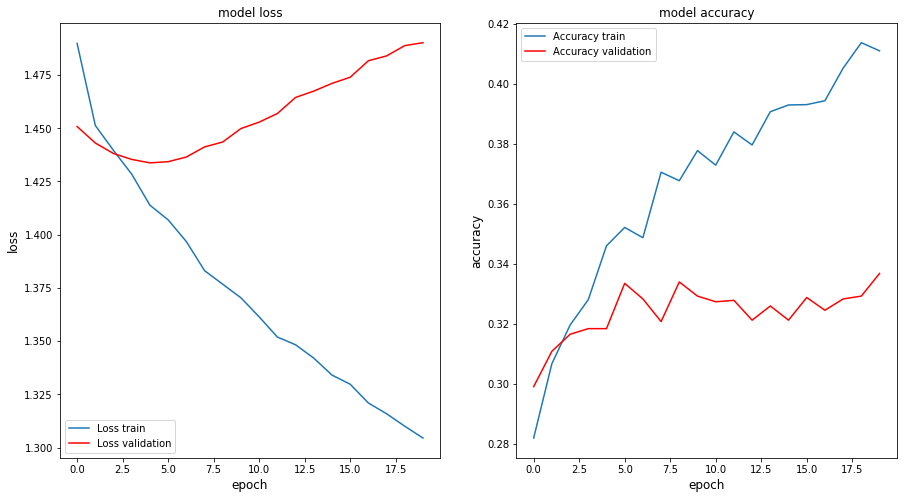

All operations completed
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 25.2255
Function value obtained: 1.2541
Current minimum: 1.2541
Iteration No: 16 started. Searching for the next optimal point.
	 batch_size 100
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
85/85 [==============================] - 2s 27ms/step - loss: 1.5041 - accuracy: 0.2712 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4642 - accuracy: 0.2907 - val_loss: 1.4480 - val_accuracy: 0.3061
Epoch 3/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4481 - accuracy: 0.3151 - val_loss: 1.4426 - val_accuracy: 0.3103
Epoch 4/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4386 - accurac

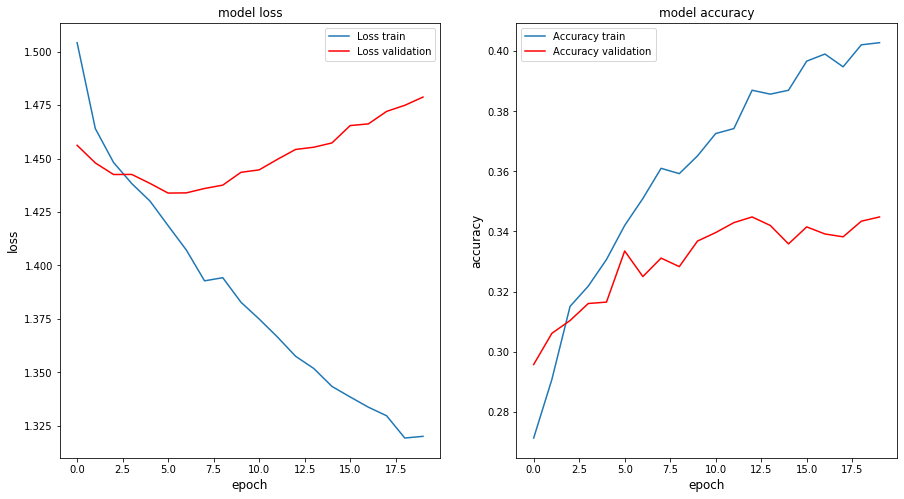

All operations completed
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 15.5233
Function value obtained: 1.2734
Current minimum: 1.2541
Iteration No: 17 started. Searching for the next optimal point.
	 batch_size 100
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
85/85 [==============================] - 2s 21ms/step - loss: 1.5022 - accuracy: 0.2753 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4629 - accuracy: 0.2936 - val_loss: 1.4496 - val_accuracy: 0.3099
Epoch 3/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4509 - accuracy: 0.3118 - val_loss: 1.4449 - val_accuracy: 0.3108
Epoch 4/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4359 - accuracy

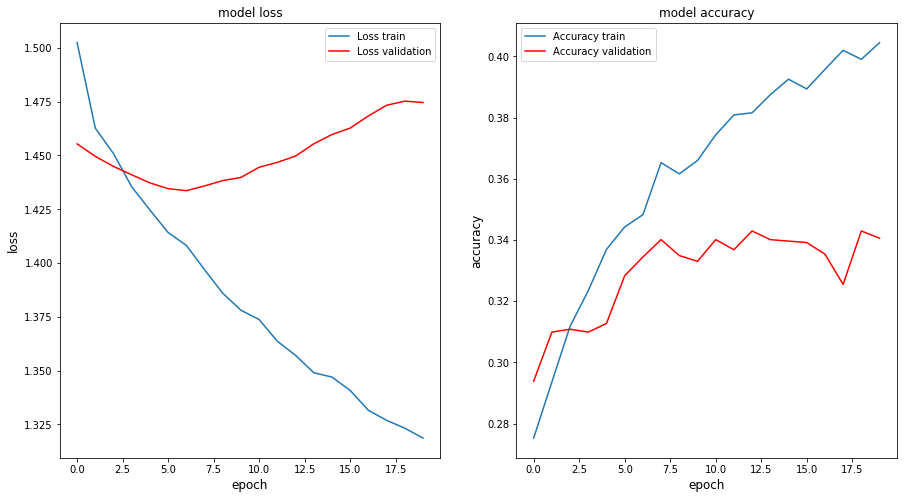

All operations completed
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 15.4748
Function value obtained: 1.2726
Current minimum: 1.2541
Iteration No: 18 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 74
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4975 - accuracy: 0.2774 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4541 - accuracy: 0.3079 - val_loss: 1.4443 - val_accuracy: 0.3075
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4436 - accuracy: 0.3220 - val_loss: 1.4379 - val_accuracy: 0.3151
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4306 - ac

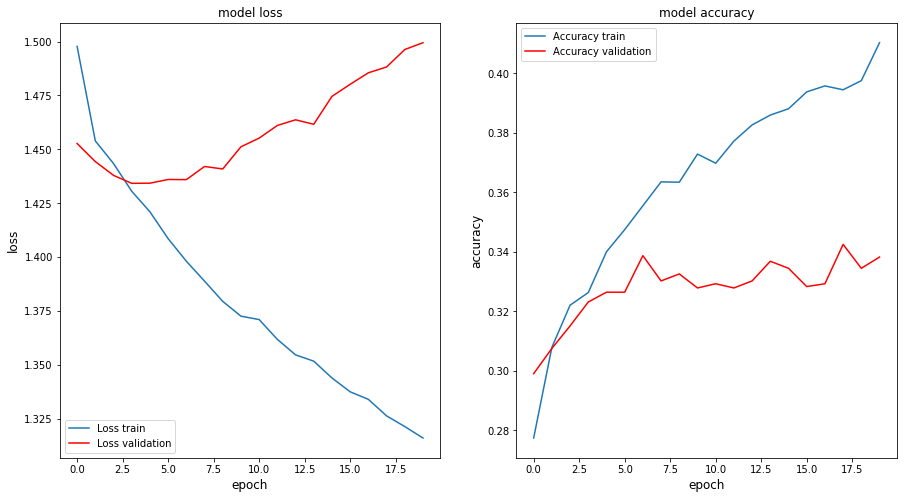

All operations completed
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 25.0606
Function value obtained: 1.2614
Current minimum: 1.2541
Iteration No: 19 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 97
	 hidden_layer_size_2 90
	 hidden_layer_size_3 97
	 learning_rate 0.0009906497510630053
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 3s 18ms/step - loss: 1.4960 - accuracy: 0.2689 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4535 - accuracy: 0.3006 - val_loss: 1.4425 - val_accuracy: 0.3165
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4413 - accuracy: 0.3185 - val_loss: 1.4371 - val_accuracy: 0.3198
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - lo

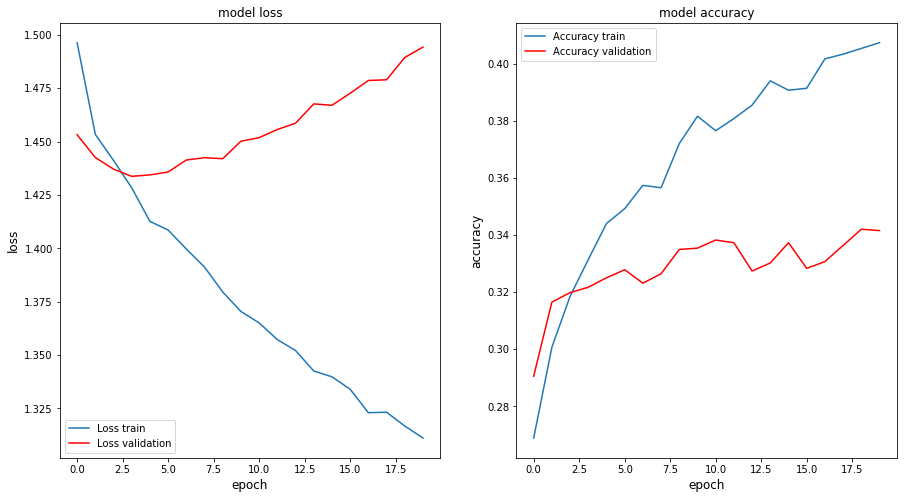

All operations completed
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 25.9092
Function value obtained: 1.2570
Current minimum: 1.2541
Iteration No: 20 started. Searching for the next optimal point.
	 batch_size 54
	 hidden_layer_size_1 18
	 hidden_layer_size_2 31
	 hidden_layer_size_3 56
	 learning_rate 0.0009759005296555527
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
157/157 [==============================] - 2s 14ms/step - loss: 1.5262 - accuracy: 0.2699 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
157/157 [==============================] - 1s 6ms/step - loss: 1.4832 - accuracy: 0.2789 - val_loss: 1.4569 - val_accuracy: 0.3004
Epoch 3/20
157/157 [==============================] - 1s 7ms/step - loss: 1.4631 - accuracy: 0.2986 - val_loss: 1.4502 - val_accuracy: 0.3061
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - lo

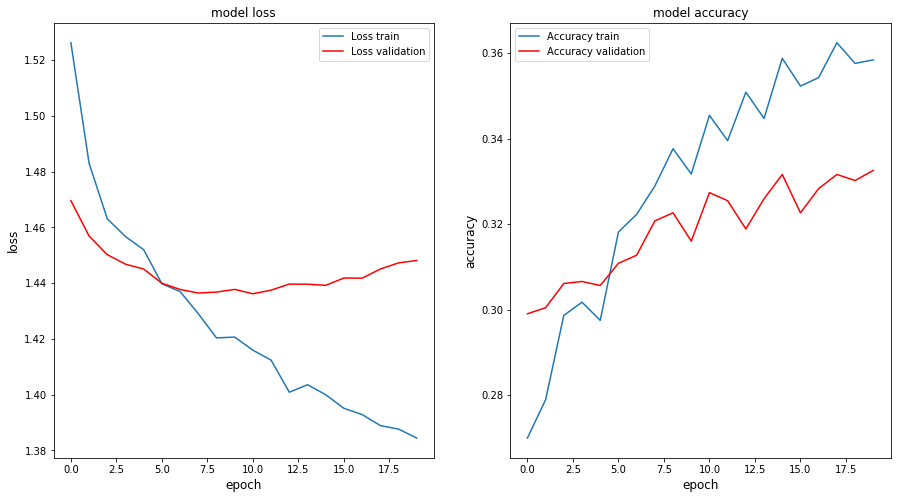

All operations completed
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 23.3495
Function value obtained: 1.3487
Current minimum: 1.2541


In [0]:
dataset, dev_dataset, test_dataset = load_dataset()
nlabels = dataset[TARGET_COL].unique().shape[0]

# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2','State']
}
# Relabel state columns

print(embedded_columns)

numeric_columns = ['Age', 'Fee']
iterations = 20
# TODO (optional) put these three types of columns in the same dictionary with "column types"
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
direct_features_input_shape = (X_train['direct_features'].shape[1],)
X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state=21, verbose=1, n_calls=iterations)

In [0]:
show_best(exploration_result)

Best value: 1.2541
Best params:
{'batch_size': 50, 'hidden_layer_size_1': 100, 'hidden_layer_size_2': 100, 'hidden_layer_size_3': 10, 'learning_rate': 0.001}


### Search param learning rate 

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Iteration No: 1 started. Evaluating function at random point.
	 batch_size 90
	 hidden_layer_size_1 71
	 hidden_layer_size_2 13
	 hidden_layer_size_3 96
	 learning_rate 0.00024851120302176203
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
95/95 [==============================] - 2s 19ms/step - loss: 1.6028 - accuracy: 0.2480 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
95/95 [==============================] - 1s 7ms/step - loss: 1.5643 - accuracy: 0.2677 - val_loss: 1.5320 - val_accuracy: 0.3004
Epoch 3/20
95/95 [==============================] - 1s 7ms/step - loss: 1.5470 - accuracy: 0.2689 - val_loss: 1.5112 - val_accuracy: 0.3061
Epoch 4/20
95/95 [==============================] - 1s 7ms/step - loss: 1.5328 - accuracy: 0.2693 - val_loss: 1.4942 - val_accuracy: 0.3061
Epoch 5/20
95/95 [===

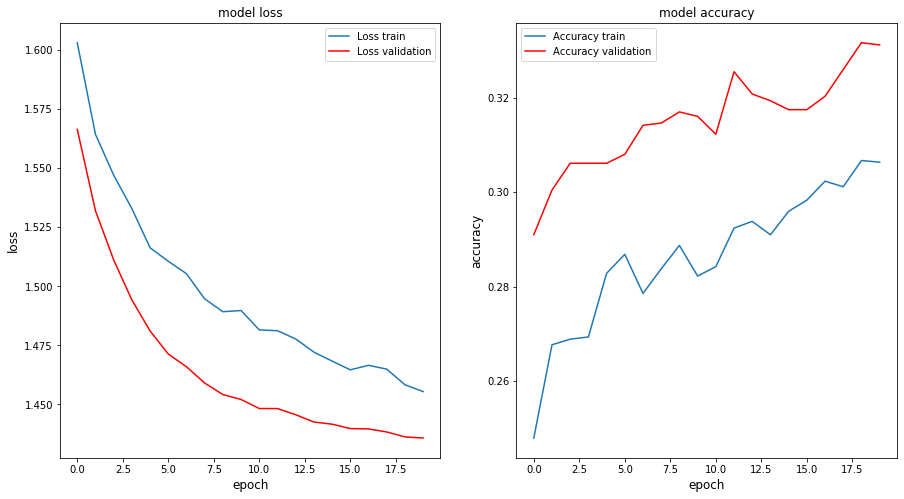

All operations completed
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.2335
Function value obtained: 1.4297
Current minimum: 1.4297
Iteration No: 2 started. Evaluating function at random point.
	 batch_size 58
	 hidden_layer_size_1 86
	 hidden_layer_size_2 41
	 hidden_layer_size_3 84
	 learning_rate 2.23543231654678e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
146/146 [==============================] - 2s 15ms/step - loss: 1.6477 - accuracy: 0.1771 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
146/146 [==============================] - 1s 6ms/step - loss: 1.6215 - accuracy: 0.2161 - val_loss: 1.5869 - val_accuracy: 0.2659
Epoch 3/20
146/146 [==============================] - 1s 6ms/step - loss: 1.6066 - accuracy: 0.2216 - val_loss: 1.5690 - val_accuracy: 0.2617
Epoch 4/20
146/146 [==============================] - 1s 7ms/step - loss: 1.5860 - ac

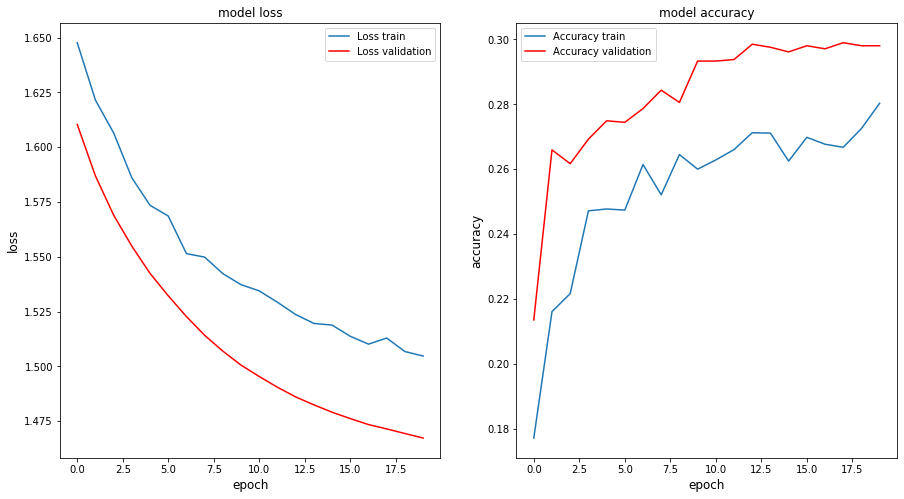

All operations completed
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 21.5315
Function value obtained: 1.4727
Current minimum: 1.4297
Iteration No: 3 started. Evaluating function at random point.
	 batch_size 73
	 hidden_layer_size_1 19
	 hidden_layer_size_2 79
	 hidden_layer_size_3 44
	 learning_rate 7.103278792699526e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
116/116 [==============================] - 2s 17ms/step - loss: 1.5803 - accuracy: 0.2422 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5480 - accuracy: 0.2649 - val_loss: 1.5197 - val_accuracy: 0.3042
Epoch 3/20
116/116 [==============================] - 1s 6ms/step - loss: 1.5279 - accuracy: 0.2664 - val_loss: 1.4965 - val_accuracy: 0.3023
Epoch 4/20
116/116 [==============================] - 1s 7ms/step - loss: 1.5117 - a

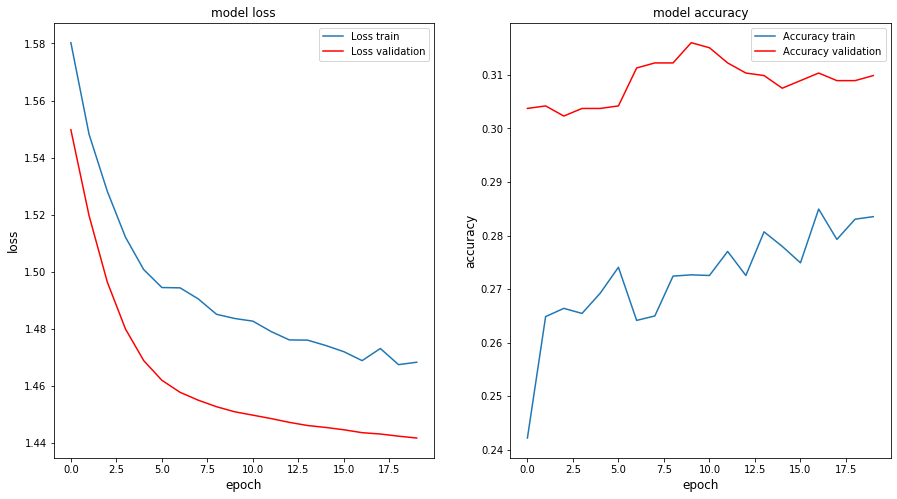

All operations completed
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.4347
Function value obtained: 1.4472
Current minimum: 1.4297
Iteration No: 4 started. Evaluating function at random point.
	 batch_size 98
	 hidden_layer_size_1 35
	 hidden_layer_size_2 62
	 hidden_layer_size_3 55
	 learning_rate 3.8205733833214285e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
87/87 [==============================] - 2s 21ms/step - loss: 1.6284 - accuracy: 0.1839 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
87/87 [==============================] - 1s 6ms/step - loss: 1.6142 - accuracy: 0.1998 - val_loss: 1.5953 - val_accuracy: 0.2187
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 1.5974 - accuracy: 0.2281 - val_loss: 1.5801 - val_accuracy: 0.2437
Epoch 4/20
87/87 [==============================] - 1s 6ms/step - loss: 1.5840 - accuracy

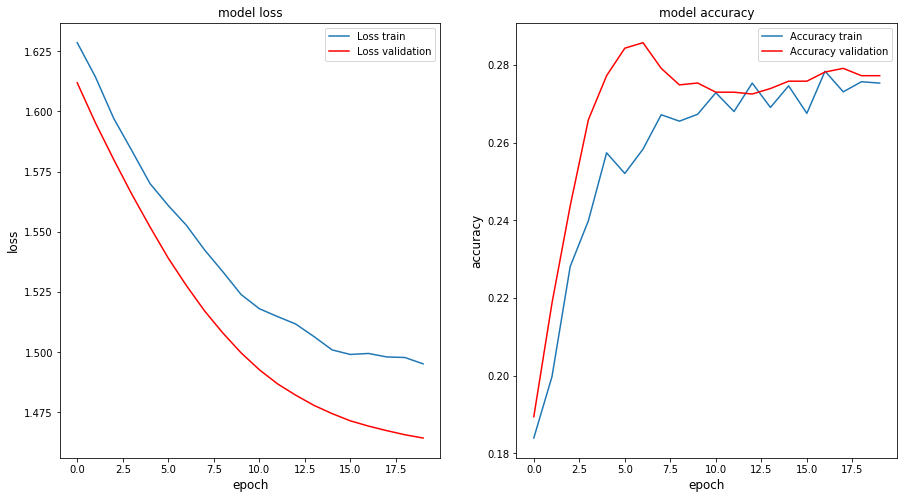

All operations completed
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.0116
Function value obtained: 1.4695
Current minimum: 1.4297
Iteration No: 5 started. Evaluating function at random point.
	 batch_size 78
	 hidden_layer_size_1 89
	 hidden_layer_size_2 93
	 hidden_layer_size_3 96
	 learning_rate 3.8504828866809955e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
109/109 [==============================] - 2s 17ms/step - loss: 1.5900 - accuracy: 0.2415 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
109/109 [==============================] - 1s 6ms/step - loss: 1.5624 - accuracy: 0.2545 - val_loss: 1.5284 - val_accuracy: 0.2976
Epoch 3/20
109/109 [==============================] - 1s 6ms/step - loss: 1.5377 - accuracy: 0.2586 - val_loss: 1.5075 - val_accuracy: 0.3009
Epoch 4/20
109/109 [==============================] - 1s 6ms/step - loss: 1.5232 - 

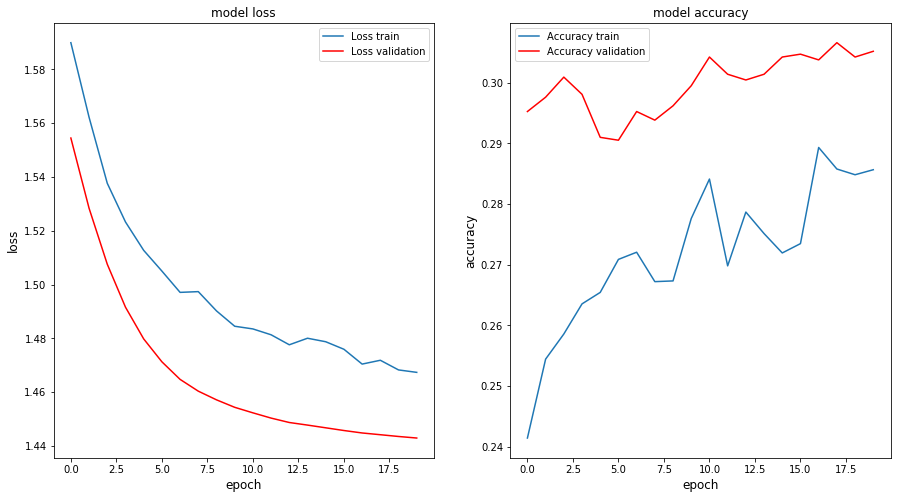

All operations completed
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 16.8705
Function value obtained: 1.4485
Current minimum: 1.4297
Iteration No: 6 started. Evaluating function at random point.
	 batch_size 62
	 hidden_layer_size_1 34
	 hidden_layer_size_2 18
	 hidden_layer_size_3 78
	 learning_rate 5.899656580061398e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
137/137 [==============================] - 3s 20ms/step - loss: 1.5958 - accuracy: 0.2520 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
137/137 [==============================] - 1s 6ms/step - loss: 1.5830 - accuracy: 0.2612 - val_loss: 1.5629 - val_accuracy: 0.2811
Epoch 3/20
137/137 [==============================] - 1s 6ms/step - loss: 1.5681 - accuracy: 0.2670 - val_loss: 1.5471 - val_accuracy: 0.2763
Epoch 4/20
137/137 [==============================] - 1s 6ms/step - loss: 1.5549 - a

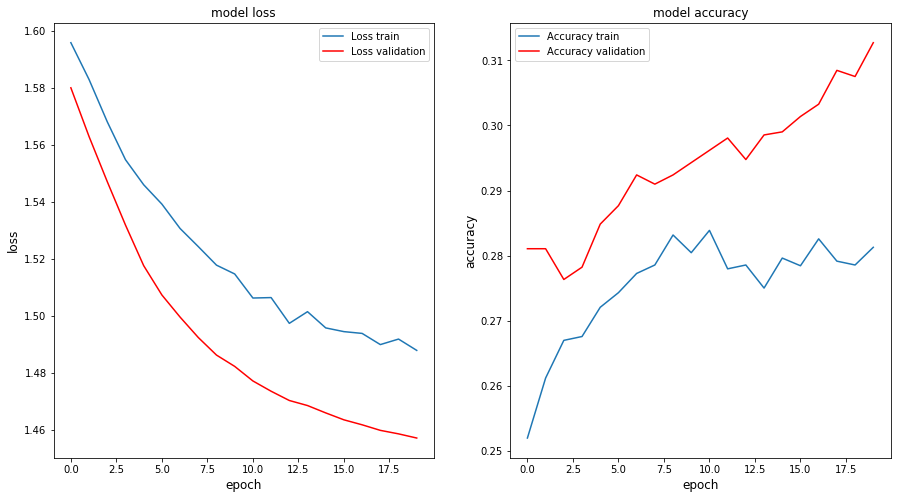

All operations completed
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 20.9486
Function value obtained: 1.4603
Current minimum: 1.4297
Iteration No: 7 started. Evaluating function at random point.
	 batch_size 80
	 hidden_layer_size_1 25
	 hidden_layer_size_2 46
	 hidden_layer_size_3 82
	 learning_rate 0.0001207316841183635
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
106/106 [==============================] - 2s 17ms/step - loss: 1.5831 - accuracy: 0.2513 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5516 - accuracy: 0.2679 - val_loss: 1.5191 - val_accuracy: 0.2900
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5276 - accuracy: 0.2645 - val_loss: 1.4915 - val_accuracy: 0.2924
Epoch 4/20
106/106 [==============================] - 1s 6ms/step - loss: 1.5139 - a

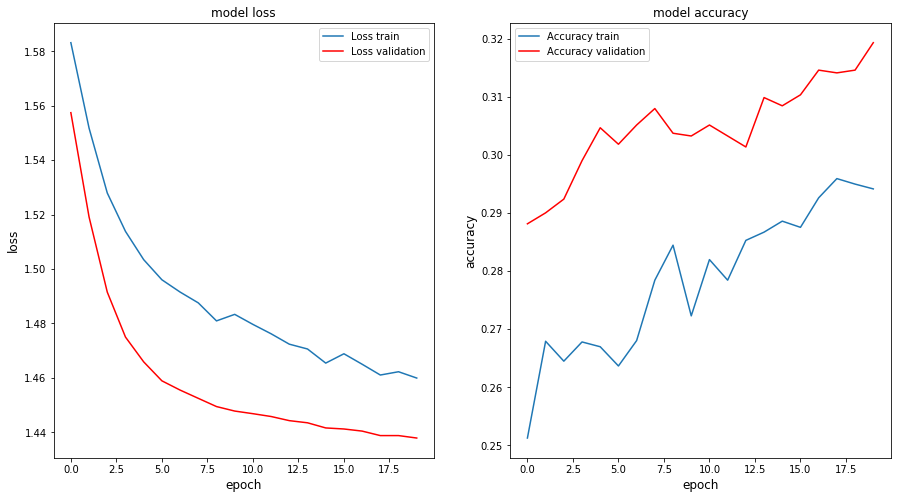

All operations completed
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 16.5360
Function value obtained: 1.4390
Current minimum: 1.4297
Iteration No: 8 started. Evaluating function at random point.
	 batch_size 88
	 hidden_layer_size_1 46
	 hidden_layer_size_2 82
	 hidden_layer_size_3 86
	 learning_rate 1.4608238804985995e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
97/97 [==============================] - 2s 18ms/step - loss: 1.5985 - accuracy: 0.2330 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
97/97 [==============================] - 1s 6ms/step - loss: 1.5913 - accuracy: 0.2369 - val_loss: 1.5746 - val_accuracy: 0.2759
Epoch 3/20
97/97 [==============================] - 1s 6ms/step - loss: 1.5822 - accuracy: 0.2526 - val_loss: 1.5667 - val_accuracy: 0.2773
Epoch 4/20
97/97 [==============================] - 1s 6ms/step - loss: 1.5708 - accuracy

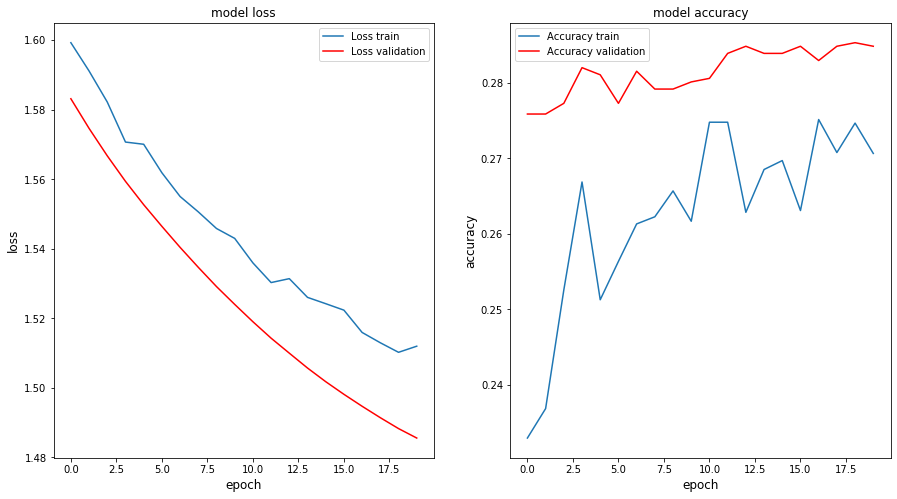

All operations completed
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 15.3053
Function value obtained: 1.4879
Current minimum: 1.4297
Iteration No: 9 started. Evaluating function at random point.
	 batch_size 97
	 hidden_layer_size_1 57
	 hidden_layer_size_2 65
	 hidden_layer_size_3 78
	 learning_rate 2.6988380143428105e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
88/88 [==============================] - 2s 20ms/step - loss: 1.6214 - accuracy: 0.1998 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
88/88 [==============================] - 1s 7ms/step - loss: 1.6092 - accuracy: 0.2269 - val_loss: 1.5896 - val_accuracy: 0.2877
Epoch 3/20
88/88 [==============================] - 1s 6ms/step - loss: 1.5964 - accuracy: 0.2328 - val_loss: 1.5780 - val_accuracy: 0.2919
Epoch 4/20
88/88 [==============================] - 1s 7ms/step - loss: 1.5890 - accuracy

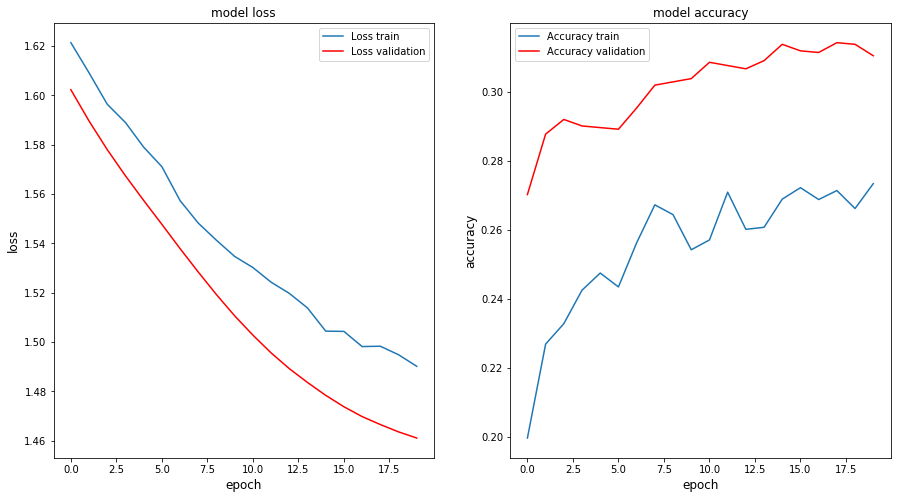

All operations completed
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 14.1594
Function value obtained: 1.4686
Current minimum: 1.4297
Iteration No: 10 started. Evaluating function at random point.
	 batch_size 95
	 hidden_layer_size_1 79
	 hidden_layer_size_2 48
	 hidden_layer_size_3 85
	 learning_rate 1.141812796139562e-05
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
90/90 [==============================] - 2s 26ms/step - loss: 1.6200 - accuracy: 0.2463 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
90/90 [==============================] - 1s 6ms/step - loss: 1.6163 - accuracy: 0.2508 - val_loss: 1.5857 - val_accuracy: 0.2867
Epoch 3/20
90/90 [==============================] - 1s 6ms/step - loss: 1.6055 - accuracy: 0.2517 - val_loss: 1.5788 - val_accuracy: 0.2886
Epoch 4/20
90/90 [==============================] - 1s 6ms/step - loss: 1.5992 - accuracy

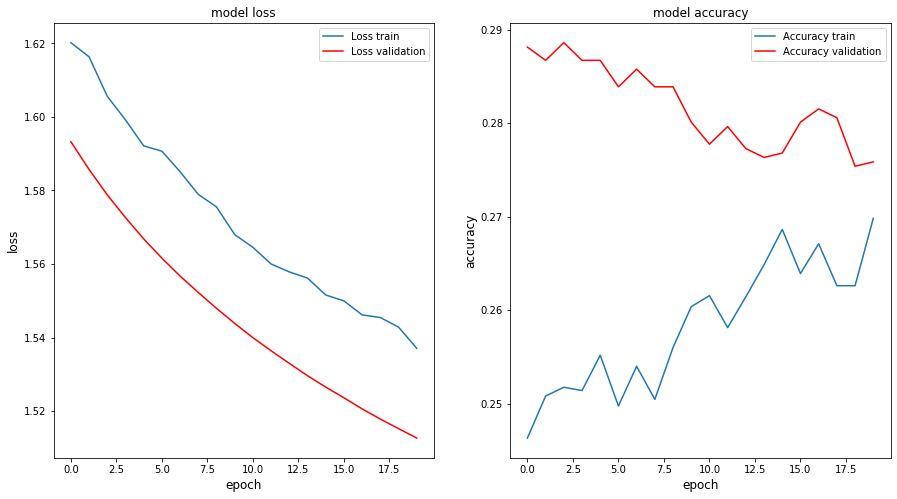

All operations completed
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 15.5745
Function value obtained: 1.5176
Current minimum: 1.4297
Iteration No: 11 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 54
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4956 - accuracy: 0.2613 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 7ms/step - loss: 1.4613 - accuracy: 0.2929 - val_loss: 1.4338 - val_accuracy: 0.3179
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4442 - accuracy: 0.3157 - val_loss: 1.4274 - val_accuracy: 0.3274
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4347 - accuracy: 0.

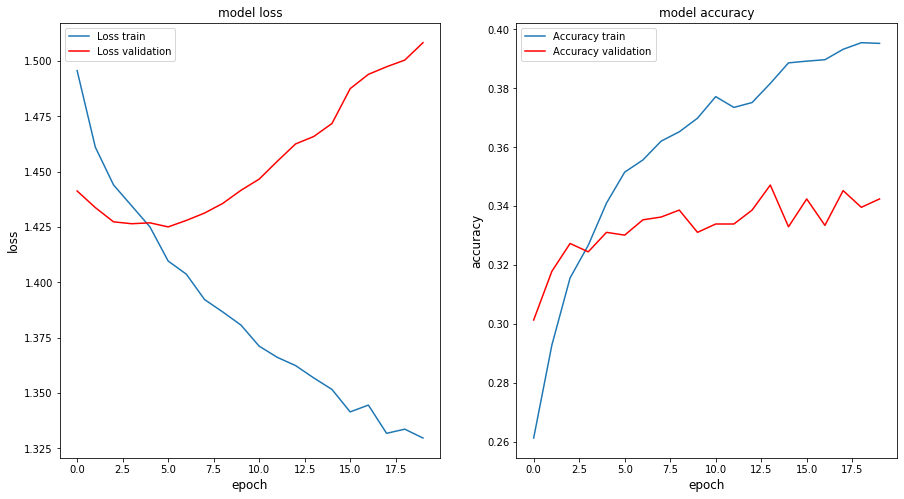

All operations completed
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 25.1512
Function value obtained: 1.2861
Current minimum: 1.2861
Iteration No: 12 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.5009 - accuracy: 0.2706 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4607 - accuracy: 0.2940 - val_loss: 1.4393 - val_accuracy: 0.3151
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4563 - accuracy: 0.2937 - val_loss: 1.4378 - val_accuracy: 0.3155
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4460 - ac

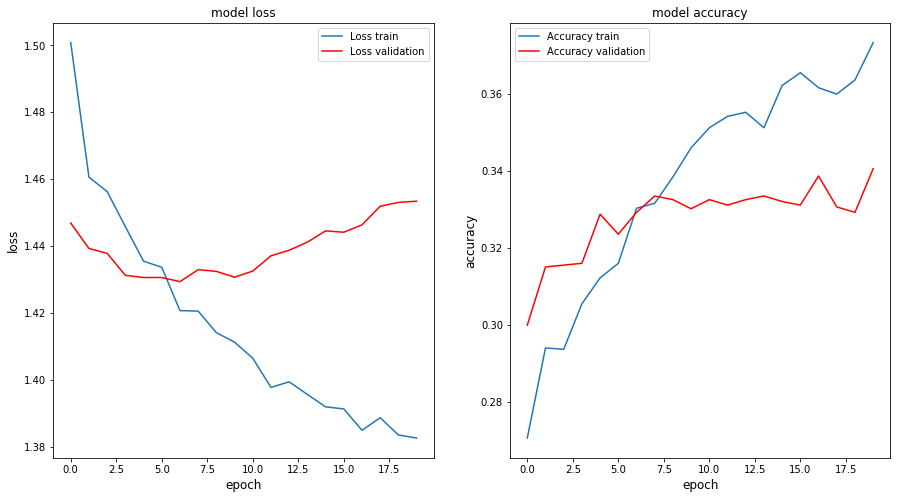

All operations completed
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 25.7127
Function value obtained: 1.3498
Current minimum: 1.2861
Iteration No: 13 started. Searching for the next optimal point.
	 batch_size 100
	 hidden_layer_size_1 10
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
85/85 [==============================] - 2s 21ms/step - loss: 1.5267 - accuracy: 0.2658 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4759 - accuracy: 0.2750 - val_loss: 1.4452 - val_accuracy: 0.3146
Epoch 3/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4595 - accuracy: 0.2887 - val_loss: 1.4374 - val_accuracy: 0.3269
Epoch 4/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4544 - accuracy

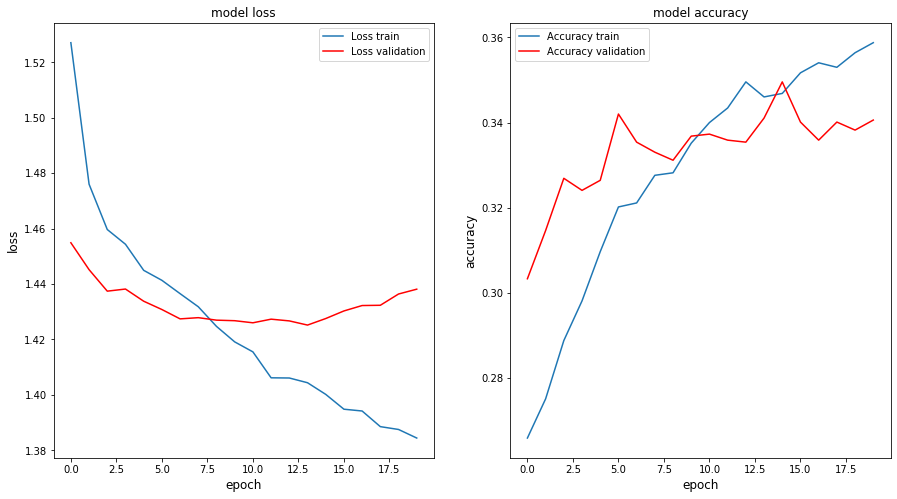

All operations completed
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 15.1797
Function value obtained: 1.3537
Current minimum: 1.2861
Iteration No: 14 started. Searching for the next optimal point.
	 batch_size 51
	 hidden_layer_size_1 84
	 hidden_layer_size_2 14
	 hidden_layer_size_3 93
	 learning_rate 0.0008037081173119142
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
166/166 [==============================] - 3s 18ms/step - loss: 1.5377 - accuracy: 0.2704 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
166/166 [==============================] - 1s 6ms/step - loss: 1.5020 - accuracy: 0.2817 - val_loss: 1.4505 - val_accuracy: 0.3108
Epoch 3/20
166/166 [==============================] - 1s 6ms/step - loss: 1.4791 - accuracy: 0.2929 - val_loss: 1.4397 - val_accuracy: 0.3283
Epoch 4/20
166/166 [==============================] - 1s 6ms/step - lo

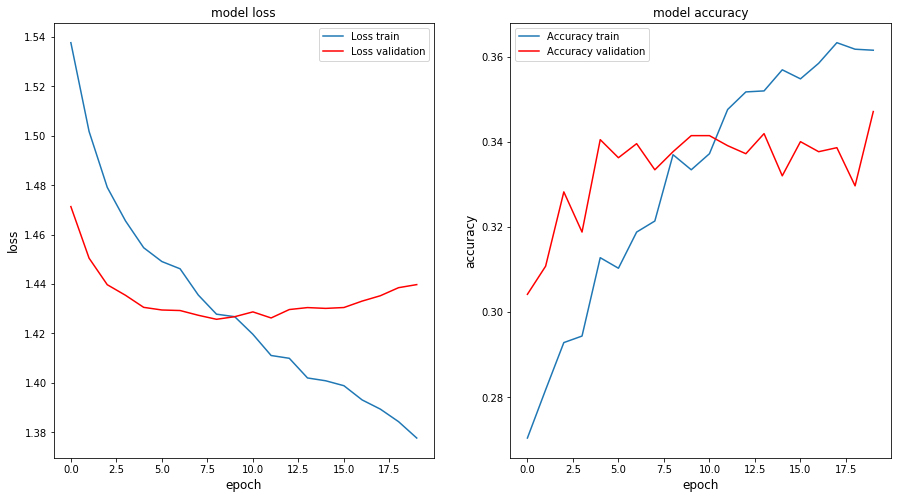

All operations completed
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 25.2047
Function value obtained: 1.3375
Current minimum: 1.2861
Iteration No: 15 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 68
	 hidden_layer_size_2 96
	 hidden_layer_size_3 99
	 learning_rate 0.0008019236119756861
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4960 - accuracy: 0.2755 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4611 - accuracy: 0.2916 - val_loss: 1.4362 - val_accuracy: 0.3080
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4545 - accuracy: 0.2985 - val_loss: 1.4327 - val_accuracy: 0.3240
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - lo

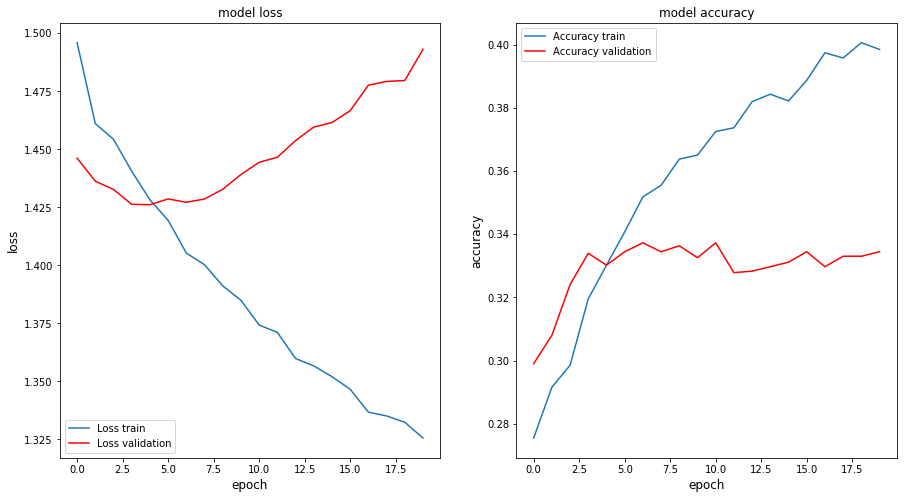

All operations completed
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 25.6913
Function value obtained: 1.2790
Current minimum: 1.2790
Iteration No: 16 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4903 - accuracy: 0.2716 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4541 - accuracy: 0.3114 - val_loss: 1.4295 - val_accuracy: 0.3222
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4453 - accuracy: 0.3206 - val_loss: 1.4259 - val_accuracy: 0.3401
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4303 - a

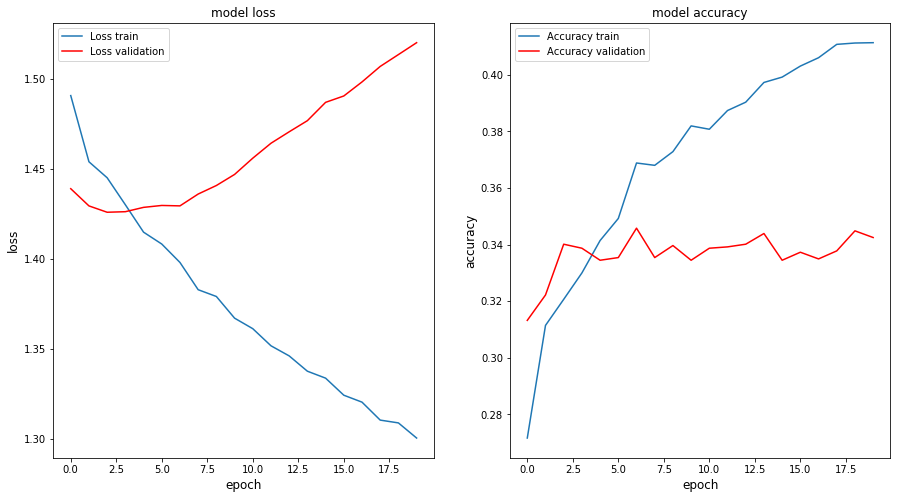

All operations completed
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 24.7838
Function value obtained: 1.2432
Current minimum: 1.2432
Iteration No: 17 started. Searching for the next optimal point.
	 batch_size 100
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 100
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
85/85 [==============================] - 2s 20ms/step - loss: 1.4954 - accuracy: 0.2744 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4634 - accuracy: 0.2982 - val_loss: 1.4369 - val_accuracy: 0.3155
Epoch 3/20
85/85 [==============================] - 1s 6ms/step - loss: 1.4467 - accuracy: 0.3103 - val_loss: 1.4307 - val_accuracy: 0.3174
Epoch 4/20
85/85 [==============================] - 1s 7ms/step - loss: 1.4377 - accurac

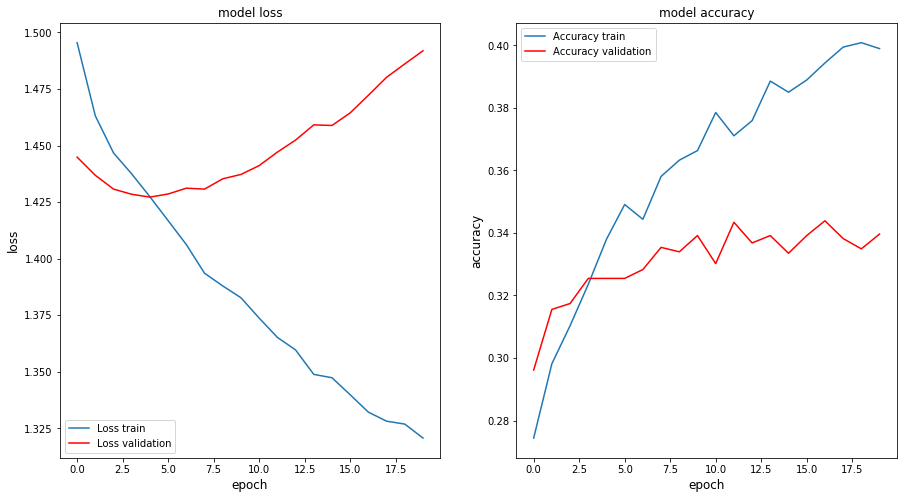

All operations completed
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 14.3166
Function value obtained: 1.2746
Current minimum: 1.2432
Iteration No: 18 started. Searching for the next optimal point.
	 batch_size 57
	 hidden_layer_size_1 99
	 hidden_layer_size_2 100
	 hidden_layer_size_3 82
	 learning_rate 0.0008798387640723619
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
149/149 [==============================] - 3s 20ms/step - loss: 1.4905 - accuracy: 0.2766 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
149/149 [==============================] - 1s 6ms/step - loss: 1.4597 - accuracy: 0.2973 - val_loss: 1.4335 - val_accuracy: 0.3122
Epoch 3/20
149/149 [==============================] - 1s 6ms/step - loss: 1.4437 - accuracy: 0.3161 - val_loss: 1.4291 - val_accuracy: 0.3245
Epoch 4/20
149/149 [==============================] - 1s 6ms/step - l

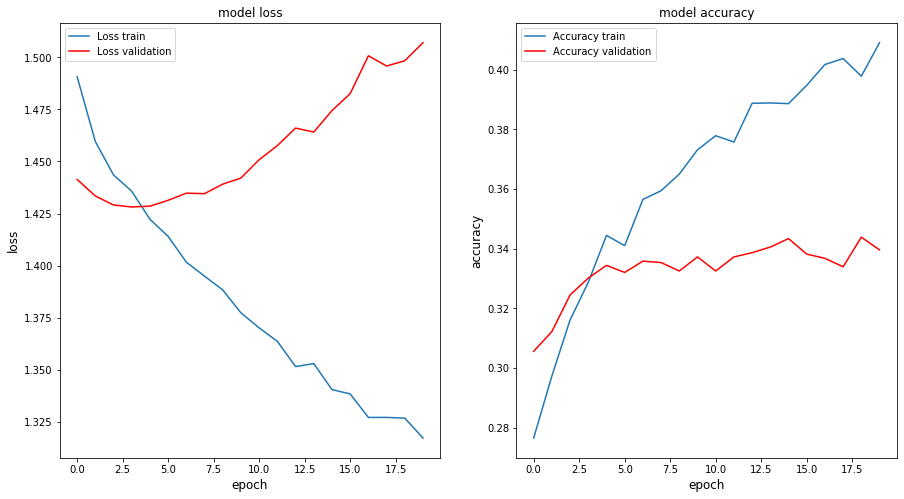

All operations completed
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 22.9227
Function value obtained: 1.2695
Current minimum: 1.2432
Iteration No: 19 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 97
	 hidden_layer_size_2 90
	 hidden_layer_size_3 97
	 learning_rate 0.0009906497510630053
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4991 - accuracy: 0.2598 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4588 - accuracy: 0.2999 - val_loss: 1.4324 - val_accuracy: 0.3240
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4440 - accuracy: 0.3184 - val_loss: 1.4285 - val_accuracy: 0.3264
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - lo

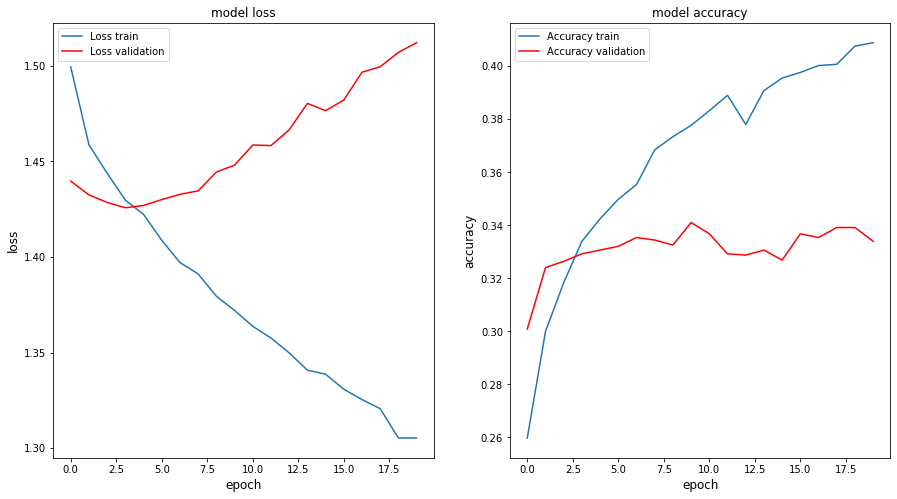

All operations completed
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 24.8109
Function value obtained: 1.2526
Current minimum: 1.2432
Iteration No: 20 started. Searching for the next optimal point.
	 batch_size 50
	 hidden_layer_size_1 100
	 hidden_layer_size_2 100
	 hidden_layer_size_3 10
	 learning_rate 0.001
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Epoch 1/20
170/170 [==============================] - 2s 14ms/step - loss: 1.4902 - accuracy: 0.2790 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4593 - accuracy: 0.2969 - val_loss: 1.4315 - val_accuracy: 0.3160
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4376 - accuracy: 0.3171 - val_loss: 1.4259 - val_accuracy: 0.3264
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 1.4280 - a

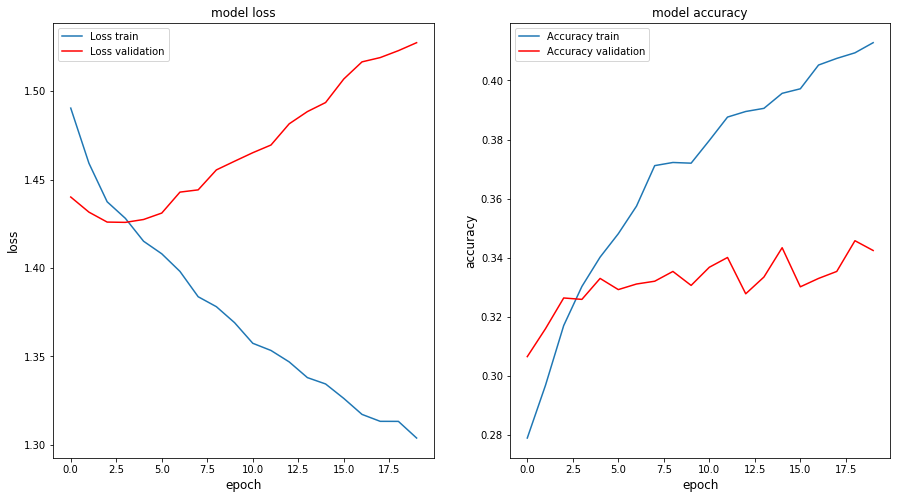

All operations completed
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 24.8761
Function value obtained: 1.2515
Current minimum: 1.2432


In [0]:
dataset, dev_dataset, test_dataset = load_dataset()
nlabels = dataset[TARGET_COL].unique().shape[0]

# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2','State']
}
# Relabel state columns

print(embedded_columns)

numeric_columns = ['Age', 'Fee']
iterations = 20
# TODO (optional) put these three types of columns in the same dictionary with "column types"
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
direct_features_input_shape = (X_train['direct_features'].shape[1],)
X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state=21, verbose=1, n_calls=iterations)

In [0]:
show_best(exploration_result)

Best value: 1.2432
Best params:
{'batch_size': 50, 'hidden_layer_size_1': 100, 'hidden_layer_size_2': 100, 'hidden_layer_size_3': 10, 'learning_rate': 0.001}


### Best

In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(35, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(62, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(45, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2','State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(8,15))
        
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(2,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________

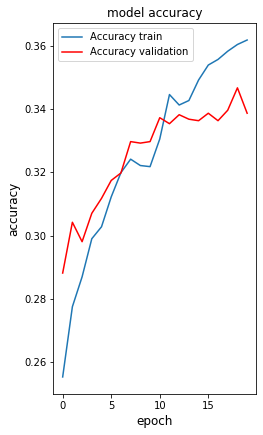

All operations completed


In [0]:
main()

## **Acerca de la búsqueda de hiperparámetros**

La búsqueda de hiperparámetros se hizo teniendo en cuenta el batch_size, la cantidad de neuronas correspondientes 
a cada una de las 3 capas ocultas de nuestro modelo, y el learning_rate.
A modo exploratorio consideramos inicialmente valores de batch_size entre 50 y 150, la cantidad de neuronas
podía variar entre 20 y 500 y la learning_rate entre 1e-5 y 1e-3. La búsqueda aleatoria de parámetros
derivó, en su mayoría, en resultados atipicos. Algunos ejemplos a mencionar son los siguientes:
* Cuando la cantidad de neuronas de la primer capa era del orden de 300, la de la segunda del orden de decenas
(37 aprox.) y la de la tercera cercana a 400, el gráfico de la función de costo sube y baja bruscamente
en cada época. Un comportamiento similar es observado en el accuracy.
* Cuando las tres capas ocultas poseen un gran número de neuronas, el modelo tiende a overfitear. Este comportamiento 
se observa en el experimento que posee 440, 465 y 479 neuronas por capa y una tasa de aprendizaje de 7e-4. Las funciones loss en train y validación tienen comportamientos opuestos: la loss en train es notablemente decreciente
mientras que la loss en validación sube abruptamente conforme pasan las épocas. Otro indicio de overfiteo se observa en el accuracy: mientras el accuracy en train crece constantemente con las épocas, el accuracy en validación se mantiene prácticamente constante.
* Los valores de loss y accuracy en train y validación dan constantes cuando la primer y la última capa tienen pocas neuronas (25 aprox) y por el contrario la capa central tiene del orden de 500.
En base a estas primeras observaciones, concluimos que este problema no debe ser tratado con numerosas neuronas en cada capa. 

En un segundo intento restringimos más la búsqueda de hiperparámetros, permitiéndole al buscador explorar entre 10 y 100 neuronas por capa. En esta nueva búsqueda de un modelo ideal, encontramos que un pequeño cambio en los hiperparámetros podía resultar en desempeños muy diferentes del modelo. Por otro lado, nos encontramos con un comportamiento invertido entre las funciones de loss y accuracy en train y en validación, donde se observa que para un entrenamiento mediocre del modelo se obtienen buenos resultados en la validación. No hemos llegado a un consenso para explicar estos resultados. En general, se obtienen malos resultados para tasas de aprendizaje altas (1e-1, 1e-2).

Nuestro buscador de los mejores hiperparámetros tenía como criterio evaluar el menor valor en loss conseguido, sin embargo, no consideramos que este criterio sea suficiente. Podemos decir que el buscador de hiperparámetros no nos llevó a los resultados esperados, pero sí nos dió indicios de qué combinaciones entre valores fracasaban.
En base a este aprendizaje concluímos que el mejor resultado se obtenía considerando:

 args = {

      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    
    } 


### Eliminamos Columnas Breed

In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(35, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(62, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(45, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'State': 15}
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 3)         45          State[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 3)]          0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 28)]         0                                         

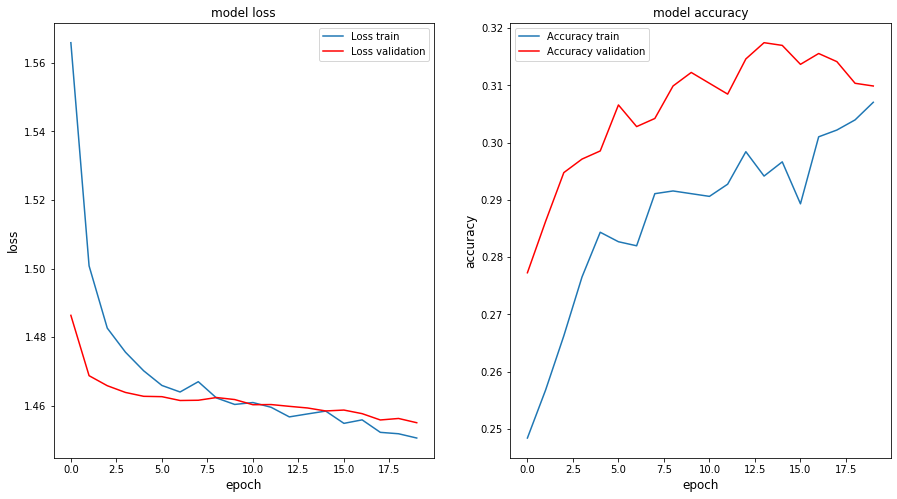

All operations completed


In [0]:
main()

### Eliminamos Color

In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(35, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(62, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(45, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1', 'Breed2','State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________

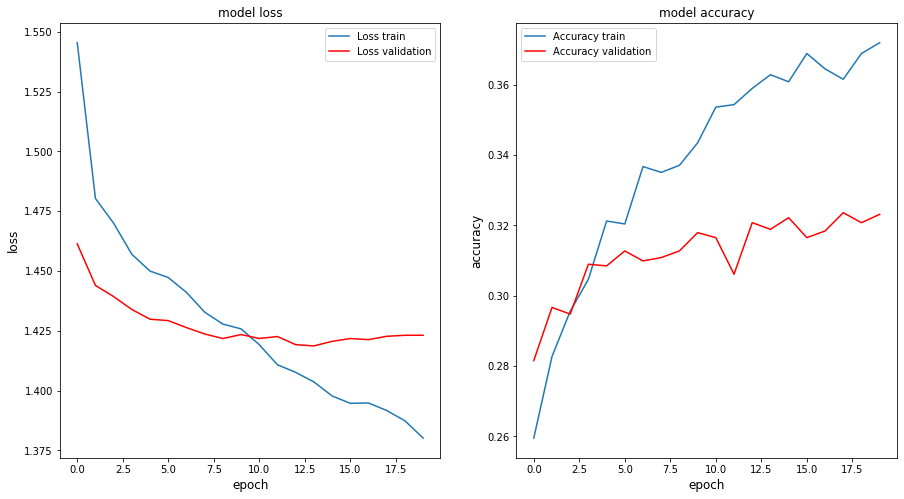

All operations completed


In [0]:
main()

### Eliminamos Age

In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(35, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(62, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(45, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Type', 'Color1', 'Color2',  'Color3']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1', 'Breed2','State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________

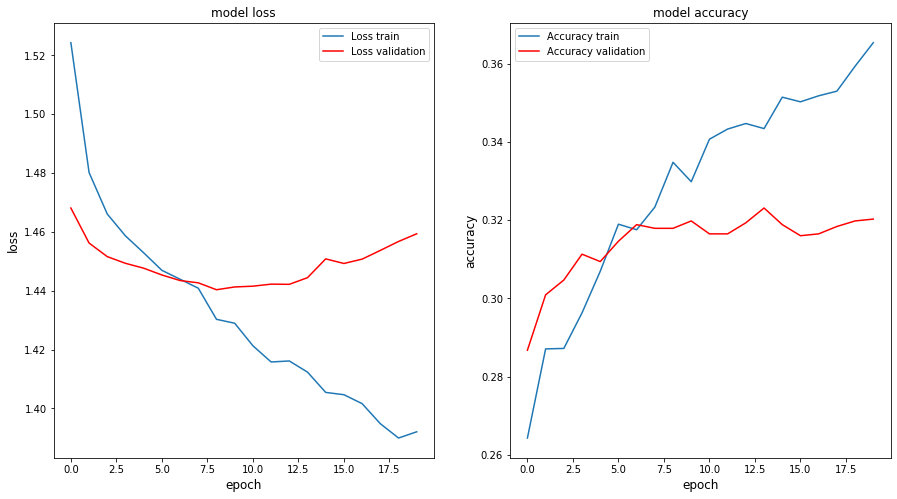

All operations completed


In [0]:
main()

### Eliminamos Fee

In [0]:
def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)

    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    #features = direct_features_input
    dense1 = layers.Dense(35, activation='relu')(features)
    dropout1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(62, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(45, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout3)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [35,62,45],
      'dropout': [0.3,0,5, 0.5],
      'dataset_dir' : '',
      'batch_size' : 60,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Type', 'Color1', 'Color2',  'Color3']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1', 'Breed2','State']
    }
    # Relabel state columns
    
    print(embedded_columns)

    numeric_columns = ['Age']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
  
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '2') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
    
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,8))
        
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='12')
        plt.xlabel('epoch', size='12')
        plt.legend()
                
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Accuracy train')
        plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='12')
        plt.xlabel('epoch',size='12')
        plt.legend()
        plt.show()
        
    print('All operations completed')

Training samples 8465, test_samples 4411
{'Breed1': 308, 'Breed2': 308, 'State': 15}
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
State (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________

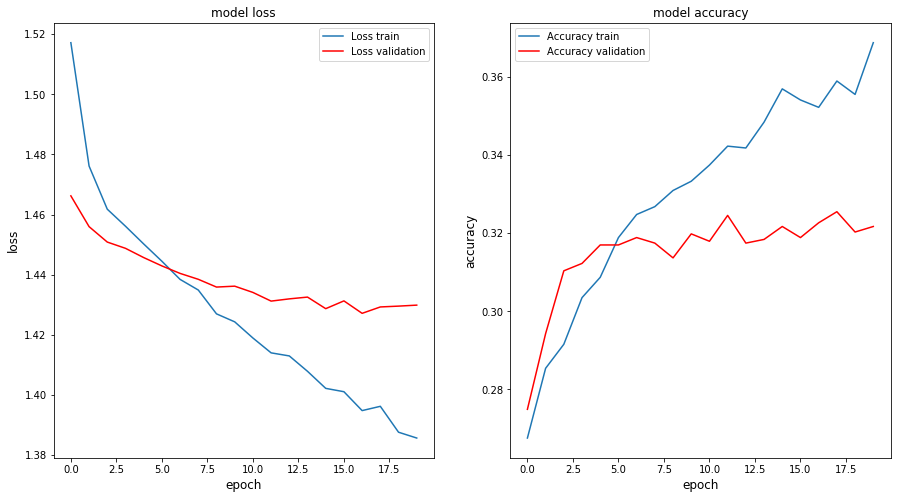

All operations completed


In [0]:
main()

# Conclusiones a partir de la eliminación columnas

Se hicieron pruebas eliminando Breed (1 y 2), Color(1,2 y 3), Age y Fee. En todas las pruebas no se encontraron diferencias notable entre loss y acurracy. Obtuvimos una loss que variaba entre 1.41 a 1.44 y un acurracy que variaba entre 0.31 y 0.33 en validación. En la prueba en que se consideran todas las variables la loss es de 1.44 y accuracy 0.34 en el conjunto de validación. Por lo que el mejor resultado se obtuvo con todas las variables.

Creemos que la diferencia va a ser notable considerando la descripción y la foto del animal. En primera instancia creimos que las columnas de color iban a tener mayor relevancia, pero los resultados muestran lo contrario. 

### Script para guardar mlruns en Drive.

- Es necesario tener creada una carpeta llamada MLFLOW.


In [0]:
!git clone https://github.com/RaviSoji/colab_utils.git  # Include the "!".


Cloning into 'colab_utils'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 22.95 KiB | 11.48 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [0]:
import colab_utils
drive = colab_utils.get_gdrive()

In [0]:
from datetime import datetime
import zipfile
now = datetime.now().strftime("%d%m%Y%H%M%S")

zipname = 'model_v' + now
def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/mlruns/')

colab_utils.push_to_gdrive(drive, zipname+".zip", "/MLFLOW/")

GoogleDriveFile({'parents': [{'kind': 'drive#parentReference', 'id': '1OS0McNfxuEz6ixS7McfjWPqePdN7HN2b', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp/parents/1OS0McNfxuEz6ixS7McfjWPqePdN7HN2b', 'parentLink': 'https://www.googleapis.com/drive/v2/files/1OS0McNfxuEz6ixS7McfjWPqePdN7HN2b', 'isRoot': False}], 'title': 'model_v13112019004140.zip', 'mimeType': 'application/zip', 'kind': 'drive#file', 'id': '1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp', 'etag': '"ARKMDIyi8Qt0WnRZL7i9hjeAaoo/MTU3MzYwNTcwMzM5MA"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp', 'webContentLink': 'https://drive.google.com/uc?id=1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp&export=download', 'alternateLink': 'https://drive.google.com/file/d/1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/1wwo2GT5Tq7r2TpaZxIqIAQQyRVRX6Shp/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent